In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP, RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP)
print(USER_IDS)

../data/pybossa/pybossa.pkl
5


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FOLDER_MODELS = '../models/autoencoders_requirements/'
FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
_, _, x, mrks = pkl.load(open(FILE_DUMP, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5598 - accuracy: 0.7141 - precision: 0.9684 - recall: 0.7127 - f1: 0.8110 - specificity: 0.6311 - negative_predictive_value: 0.1644 - matthews_correlation_coefficient: 0.2277 - val_loss: 0.6381 - val_accuracy: 0.5941 - val_precision: 0.9943 - val_recall: 0.5809 - val_f1: 0.7283 - val_specificity: 0.7950 - val_negative_predictive_value: 0.1246 - val_matthews_correlation_coefficient: 0.2192ccuracy: 0.7155 - precision: 0.9684 - recall: 0.7155 - f1: 0.8130 - specificity: 0.6364 - negative_predictive_value: 0.1662 - matthews_correlation_coefficient: 0.230

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21916, saving model to ../models/autoencoders_requirements/blurred_2020_03_20-23_42_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5093 - accuracy: 0.7108 - precision: 0.9806 - recall: 0.7089 - f1: 0.81

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4501 - accuracy: 0.7531 - precision: 0.9856 - recall: 0.7486 - f1: 0.8475 - specificity: 0.7200 - negative_predictive_value: 0.1791 - matthews_correlation_coefficient: 0.2766 - val_loss: 0.3795 - val_accuracy: 0.8265 - val_precision: 0.9793 - val_recall: 0.8362 - val_f1: 0.9007 - val_specificity: 0.6351 - val_negative_predictive_value: 0.2267 - val_matthews_correlation_coefficient: 0.3088

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.31943
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4499 - accuracy: 0.7649 - precision: 0.9849 - recall: 0.7628 - f1: 0.8566 - specificity: 0.7012 - negative_predictive_value: 0.1872 - matthews_correlation_coefficient: 0.2831 - val_loss: 0.2712 - val_accuracy: 0.8873 - val_precision: 0.9667 - val_recall: 0.9126 - val_f1: 0.9384 - val_specificity: 0.4360 - val_negative_predictive_value: 0.2909 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.33086
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4211 - accuracy: 0.7900 - precision: 0.9862 - recall: 0.7877 - f1: 0.8724 - specificity: 0.6938 - negative_predictive_value: 0.2108 - matthews_correlation_coefficient: 0.3111 - val_loss: 0.4039 - val_accuracy: 0.8066 - val_precision: 0.9832 - val_recall: 0.8111 - val_f1: 0.8870 - val_specificity: 0.6734 - val_negative_predictive_value: 0.2098 - val_matthews_correlation_coefficient: 0.3049

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.33086
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4218 - accuracy: 0.7863 - precision: 0.9826 - recall: 0.7845 - f1: 0.8691 - specificity: 0.7436 - negative_predictive_value: 0.2036 - matthews_correlation_coefficient: 0.3139 - val_loss: 0.4358 - val_accuracy: 0.7840 - val_precision: 0.9850 - val_recall: 0.7867 - val_f1: 0.8733 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4021 - accuracy: 0.7913 - precision: 0.9887 - recall: 0.7872 - f1: 0.8734 - specificity: 0.7363 - negative_predictive_value: 0.2182 - matthews_correlation_coefficient: 0.3283 - val_loss: 0.4768 - val_accuracy: 0.7658 - val_precision: 0.9877 - val_recall: 0.7648 - val_f1: 0.8601 - val_specificity: 0.7342 - val_negative_predictive_value: 0.1909 - val_matthews_correlation_coefficient: 0.3017

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.35418
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3893 - accuracy: 0.7972 - precision: 0.9888 - recall: 0.7937 - f1: 0.8775 - specificity: 0.7413 - negative_predictive_value: 0.2329 - matthews_correlation_coefficient: 0.3418 - val_loss: 0.2927 - val_accuracy: 0.8760 - val_precision: 0.9790 - val_recall: 0.8901 - val_f1: 0.9313 - val_specificity: 0.6387 - val_negative_predictive_value: 0.3060 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.38569
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3805 - accuracy: 0.8033 - precision: 0.9902 - recall: 0.8001 - f1: 0.8819 - specificity: 0.7606 - negative_predictive_value: 0.2417 - matthews_correlation_coefficient: 0.3576 - val_loss: 0.3733 - val_accuracy: 0.8213 - val_precision: 0.9846 - val_recall: 0.8269 - val_f1: 0.8974 - val_specificity: 0.7050 - val_negative_predictive_value: 0.2367 - val_matthews_correlation_coefficient: 0.3449

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.38569
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3603 - accuracy: 0.8286 - precision: 0.9905 - recall: 0.8230 - f1: 0.8965 - specificity: 0.7828 - negative_predictive_value: 0.2562 - matthews_correlation_coefficient: 0.3843 - val_loss: 0.5852 - val_accuracy: 0.7138 - val_precision: 0.9915 - val_recall: 0.7087 - val_f1: 0.8236 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.38569
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3484 - accuracy: 0.8315 - precision: 0.9932 - recall: 0.8272 - f1: 0.9004 - specificity: 0.8168 - negative_predictive_value: 0.2715 - matthews_correlation_coefficient: 0.4070 - val_loss: 0.2975 - val_accuracy: 0.8586 - val_precision: 0.9848 - val_recall: 0.8667 - val_f1: 0.9206 - val_specificity: 0.6802 - val_negative_predictive_value: 0.2745 - val_matthews_correlation_coefficient: 0.3747

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.38569
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3482 - accuracy: 0.8182 - precision: 0.9917 - recall: 0.8100 - f1: 0.8886 - specificity: 0.8023 - negative_predictive_value: 0.2551 - matthews_correlation_coefficient: 0.3817 - val_loss: 0.2604 - val_accuracy: 0.8751 - val_precision: 0.9783 - val_recall: 0.8901 - val_f1: 0.9309 - val_spe

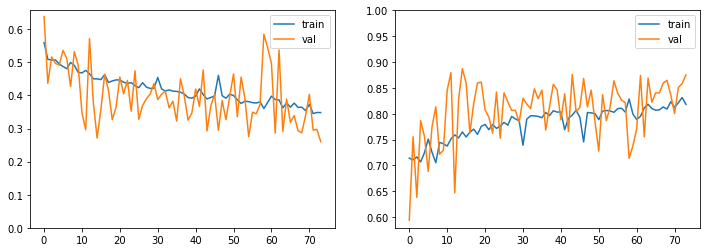

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6643 - accuracy: 0.6106 - precision: 0.7714 - recall: 0.6146 - f1: 0.6685 - specificity: 0.6146 - negative_predictive_value: 0.4365 - matthews_correlation_coefficient: 0.2211 - val_loss: 0.6333 - val_accuracy: 0.6644 - val_precision: 0.7690 - val_recall: 0.7350 - val_f1: 0.7466 - val_specificity: 0.5297 - val_negative_predictive_value: 0.4845 - val_matthews_correlation_coefficient: 0.2579

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25789, saving model to ../models/autoencoders_requirements/looking_away_2020_03_20-23_53_11.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6550 - accuracy: 0.6269 - precision: 0.7599 - recall: 0.6384 - f1: 0.6821 - specificity: 0.5931 - negative_predictive_value: 0.4609 - matthews_correlation_coefficient: 0.2321 - val_loss: 0.7130 - val_accuracy: 0.5542 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6198 - accuracy: 0.6746 - precision: 0.7977 - recall: 0.6943 - f1: 0.7357 - specificity: 0.6311 - negative_predictive_value: 0.5068 - matthews_correlation_coefficient: 0.3155 - val_loss: 0.6102 - val_accuracy: 0.6990 - val_precision: 0.8149 - val_recall: 0.7321 - val_f1: 0.7657 - val_specificity: 0.6377 - val_negative_predictive_value: 0.5236 - val_matthews_correlation_coefficient: 0.3526

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37478
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6173 - accuracy: 0.6792 - precision: 0.8013 - recall: 0.7053 - f1: 0.7419 - specificity: 0.6394 - negative_predictive_value: 0.5198 - matthews_correlation_coefficient: 0.3315 - val_loss: 0.5999 - val_accuracy: 0.6869 - val_precision: 0.7770 - val_recall: 0.7705 - val_f1: 0.7681 - val_specificity: 0.5252 - val_negative_predictive_value: 0.5167 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5764 - accuracy: 0.7132 - precision: 0.8195 - recall: 0.7369 - f1: 0.7715 - specificity: 0.6573 - negative_predictive_value: 0.5537 - matthews_correlation_coefficient: 0.3828 - val_loss: 0.5457 - val_accuracy: 0.7268 - val_precision: 0.7854 - val_recall: 0.8256 - val_f1: 0.8017 - val_specificity: 0.5181 - val_negative_predictive_value: 0.5768 - val_matthews_correlation_coefficient: 0.3514

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39150
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5743 - accuracy: 0.7095 - precision: 0.8218 - recall: 0.7290 - f1: 0.7658 - specificity: 0.6748 - negative_predictive_value: 0.5577 - matthews_correlation_coefficient: 0.3903 - val_loss: 0.5919 - val_accuracy: 0.7016 - val_precision: 0.7979 - val_recall: 0.7608 - val_f1: 0.7739 - val_specificity: 0.5890 - val_negative_predictive_value: 0.5336 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5665 - accuracy: 0.7067 - precision: 0.8241 - recall: 0.7035 - f1: 0.7524 - specificity: 0.7008 - negative_predictive_value: 0.5501 - matthews_correlation_coefficient: 0.3877 - val_loss: 0.5765 - val_accuracy: 0.6930 - val_precision: 0.7976 - val_recall: 0.7440 - val_f1: 0.7645 - val_specificity: 0.5958 - val_negative_predictive_value: 0.5228 - val_matthews_correlation_coefficient: 0.3286

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39150
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5562 - accuracy: 0.7137 - precision: 0.8237 - recall: 0.7167 - f1: 0.7609 - specificity: 0.6936 - negative_predictive_value: 0.5533 - matthews_correlation_coefficient: 0.3922 - val_loss: 0.6034 - val_accuracy: 0.6748 - val_precision: 0.8431 - val_recall: 0.6496 - val_f1: 0.7266 - val_specificity: 0.7212 - val_negative_predictive_value: 0.4903 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39150
Epoch 00058: early stopping

   Final Accuracy:  71.81%
  Final Precision:  82.77%
     Final Recall:  72.99%
  Final F-measure:  77.57%
Final Specificity:  69.45%
        Final NPV:  56.12%
        Final MCC:  40.62%
[[266 117]
 [208 562]]
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       383
           1       0.83      0.73      0.78       770

    accuracy                           0.72      1153
   macro avg       0.69      0.71      0.70      1153
weighted avg       0.74      0.72      0.72      1153



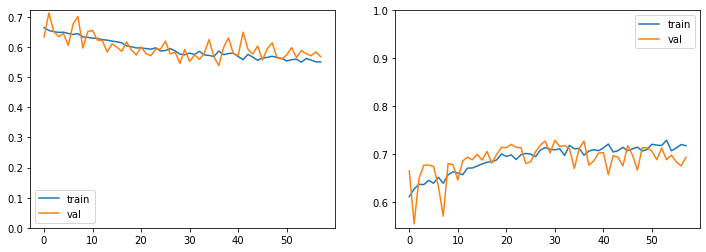

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.8314 - accuracy: 0.9915 - precision: 0.9996 - recall: 0.9920 - f1: 0.9942 - specificity: 0.0000e+00 - negative_predictive_value: 0.0000e+00 - matthews_correlation_coefficient: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.9991 - val_precision: 0.9992 - val_recall: 1.0000 - val_f1: 0.9996 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/ink_marked_creased_2020_03_21-00_01_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 3.8358 - accuracy: 0.9996 - precision: 0.9996 - recall: 1.0000 - f1: 0.9998 - specificity: 0.0000e+00 - negative_predictive_value: 0.0000e+00 - matthews_correlation_coefficient: 0.0000e+00 - val_loss: 0.0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5668 - accuracy: 0.5588 - precision: 1.0000 - recall: 0.5615 - f1: 0.7165 - specificity: 0.0069 - negative_predictive_value: 0.0013 - matthews_correlation_coefficient: 0.0025 - val_loss: 0.5389 - val_accuracy: 0.6279 - val_precision: 0.9716 - val_recall: 0.6120 - val_f1: 0.7478 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.0038

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.00327
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.8673 - accuracy: 0.6078 - precision: 0.9997 - recall: 0.6104 - f1: 0.7542 - specificity: 0.0069 - negative_predictive_value: 6.8966e-04 - matthews_correlation_coefficient: 0.0010 - val_loss: 0.6512 - val_accuracy: 0.5551 - val_precision: 0.9715 - val_recall: 0.5410 - val_f1: 0.6912 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.00327
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4929 - accuracy: 0.6223 - precision: 1.0000 - recall: 0.6214 - f1: 0.7617 - specificity: 0.0138 - negative_predictive_value: 0.0014 - matthews_correlation_coefficient: 0.0037 - val_loss: 0.6060 - val_accuracy: 0.5794 - val_precision: 0.9718 - val_recall: 0.5648 - val_f1: 0.7098 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.0028

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.00327
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4432 - accuracy: 0.6362 - precision: 1.0000 - recall: 0.6384 - f1: 0.7765 - specificity: 0.0138 - negative_predictive_value: 0.0013 - matthews_correlation_coefficient: 0.0035 - val_loss: 0.4179 - val_accuracy: 0.6956 - val_precision: 0.9720 - val_recall: 0.6781 - val_f1: 0.7951 

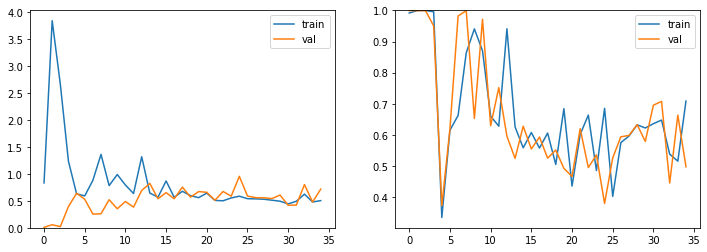

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6043 - accuracy: 0.6733 - precision: 0.7852 - recall: 0.6588 - f1: 0.6954 - specificity: 0.6806 - negative_predictive_value: 0.5295 - matthews_correlation_coefficient: 0.3384 - val_loss: 0.6397 - val_accuracy: 0.6765 - val_precision: 0.8096 - val_recall: 0.6398 - val_f1: 0.7098 - val_specificity: 0.6947 - val_negative_predictive_value: 0.4867 - val_matthews_correlation_coefficient: 0.3408

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34084, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_21-00_07_03.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5677 - accuracy: 0.7362 - precision: 0.8248 - recall: 0.7654 - f1: 0.7887 - specificity: 0.6762 - negative_predictive_value: 0.5876 - matthews_correlation_coefficient: 0.4268 - val_loss: 0.6263 - val_accuracy: 0.6808 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4763 - accuracy: 0.7954 - precision: 0.8712 - recall: 0.8216 - f1: 0.8416 - specificity: 0.7411 - negative_predictive_value: 0.6616 - matthews_correlation_coefficient: 0.5460 - val_loss: 0.4319 - val_accuracy: 0.8187 - val_precision: 0.8346 - val_recall: 0.8572 - val_f1: 0.8430 - val_specificity: 0.6677 - val_negative_predictive_value: 0.7034 - val_matthews_correlation_coefficient: 0.5562

Epoch 00015: val_matthews_correlation_coefficient improved from 0.54505 to 0.55616, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_21-00_07_03.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4719 - accuracy: 0.8028 - precision: 0.8699 - recall: 0.8379 - f1: 0.8497 - specificity: 0.7355 - negative_predictive_value: 0.6823 - matthews_correlation_coefficient: 0.5607 - val_loss: 0.4754 - val_accuracy: 0.7962 - val_precision: 0.8506 - val_recall: 0.7962 - val_f1: 0.8196 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4496 - accuracy: 0.8154 - precision: 0.8777 - recall: 0.8475 - f1: 0.8590 - specificity: 0.7600 - negative_predictive_value: 0.7029 - matthews_correlation_coefficient: 0.5926 - val_loss: 0.5272 - val_accuracy: 0.7684 - val_precision: 0.8473 - val_recall: 0.7567 - val_f1: 0.7961 - val_specificity: 0.7304 - val_negative_predictive_value: 0.5930 - val_matthews_correlation_coefficient: 0.4889

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.57090
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4490 - accuracy: 0.8139 - precision: 0.8792 - recall: 0.8441 - f1: 0.8582 - specificity: 0.7633 - negative_predictive_value: 0.6977 - matthews_correlation_coefficient: 0.5909 - val_loss: 0.5585 - val_accuracy: 0.7415 - val_precision: 0.8509 - val_recall: 0.7041 - val_f1: 0.7673 - val_specificity: 0.7605 - val_negative_predictive_value: 0.5547 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4303 - accuracy: 0.8206 - precision: 0.8832 - recall: 0.8491 - f1: 0.8626 - specificity: 0.7712 - negative_predictive_value: 0.7140 - matthews_correlation_coefficient: 0.6073 - val_loss: 0.4745 - val_accuracy: 0.7806 - val_precision: 0.8521 - val_recall: 0.7690 - val_f1: 0.8048 - val_specificity: 0.7401 - val_negative_predictive_value: 0.6142 - val_matthews_correlation_coefficient: 0.5127

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.57090
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4278 - accuracy: 0.8180 - precision: 0.8781 - recall: 0.8347 - f1: 0.8524 - specificity: 0.7710 - negative_predictive_value: 0.7002 - matthews_correlation_coefficient: 0.5925 - val_loss: 0.4484 - val_accuracy: 0.8101 - val_precision: 0.8497 - val_recall: 0.8207 - val_f1: 0.8324 - val_specificity: 0.7163 - val_negative_predictive_value: 0.6652 - val_matthews_correlation_coefficie

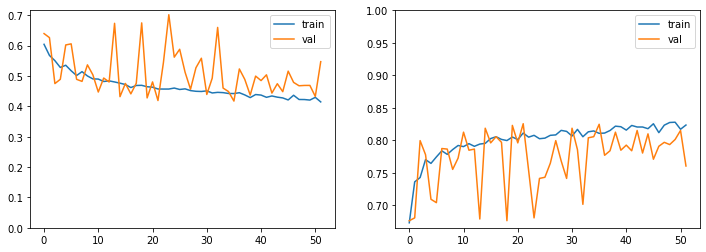

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5235 - accuracy: 0.7779 - precision: 0.9272 - recall: 0.7993 - f1: 0.8496 - specificity: 0.7009 - negative_predictive_value: 0.4323 - matthews_correlation_coefficient: 0.4169 - val_loss: 0.4254 - val_accuracy: 0.8265 - val_precision: 0.9048 - val_recall: 0.8345 - val_f1: 0.8658 - val_specificity: 0.7044 - val_negative_predictive_value: 0.5114 - val_matthews_correlation_coefficient: 0.4661

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.46608, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_21-00_14_54.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4624 - accuracy: 0.7993 - precision: 0.9448 - recall: 0.8082 - f1: 0.8674 - specificity: 0.7794 - negative_predictive_value: 0.4456 - matthews_correlation_coefficient: 0.4746 - val_loss: 0.5451 - val_accuracy: 0.7884 - val_precis

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3700 - accuracy: 0.8278 - precision: 0.9693 - recall: 0.8232 - f1: 0.8874 - specificity: 0.8645 - negative_predictive_value: 0.4904 - matthews_correlation_coefficient: 0.5540 - val_loss: 0.3782 - val_accuracy: 0.8326 - val_precision: 0.9288 - val_recall: 0.8179 - val_f1: 0.8681 - val_specificity: 0.8095 - val_negative_predictive_value: 0.5068 - val_matthews_correlation_coefficient: 0.5165

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.51983
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3728 - accuracy: 0.8291 - precision: 0.9653 - recall: 0.8246 - f1: 0.8863 - specificity: 0.8397 - negative_predictive_value: 0.4969 - matthews_correlation_coefficient: 0.5490 - val_loss: 0.5449 - val_accuracy: 0.7485 - val_precision: 0.9485 - val_recall: 0.6977 - val_f1: 0.8020 - val_specificity: 0.9136 - val_negative_predictive_value: 0.3995 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.53452
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3394 - accuracy: 0.8527 - precision: 0.9726 - recall: 0.8501 - f1: 0.9052 - specificity: 0.8803 - negative_predictive_value: 0.5396 - matthews_correlation_coefficient: 0.6048 - val_loss: 0.4610 - val_accuracy: 0.8031 - val_precision: 0.9515 - val_recall: 0.7612 - val_f1: 0.8442 - val_specificity: 0.9172 - val_negative_predictive_value: 0.4648 - val_matthews_correlation_coefficient: 0.5258

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.53452
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3393 - accuracy: 0.8508 - precision: 0.9722 - recall: 0.8479 - f1: 0.9030 - specificity: 0.8764 - negative_predictive_value: 0.5516 - matthews_correlation_coefficient: 0.6102 - val_loss: 0.4227 - val_accuracy: 0.8291 - val_precision: 0.9423 - val_recall: 0.8002 - val_f1: 0.8637 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3127 - accuracy: 0.8581 - precision: 0.9746 - recall: 0.8551 - f1: 0.9086 - specificity: 0.8839 - negative_predictive_value: 0.5481 - matthews_correlation_coefficient: 0.6135 - val_loss: 0.4566 - val_accuracy: 0.8049 - val_precision: 0.9493 - val_recall: 0.7653 - val_f1: 0.8456 - val_specificity: 0.9071 - val_negative_predictive_value: 0.4681 - val_matthews_correlation_coefficient: 0.5241

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.55395
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3153 - accuracy: 0.8605 - precision: 0.9747 - recall: 0.8581 - f1: 0.9106 - specificity: 0.8687 - negative_predictive_value: 0.5501 - matthews_correlation_coefficient: 0.6112 - val_loss: 0.4391 - val_accuracy: 0.8231 - val_precision: 0.9473 - val_recall: 0.7886 - val_f1: 0.8593 - val_specificity: 0.8988 - val_negative_predictive_value: 0.4909 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3063 - accuracy: 0.8594 - precision: 0.9742 - recall: 0.8531 - f1: 0.9074 - specificity: 0.8928 - negative_predictive_value: 0.5478 - matthews_correlation_coefficient: 0.6182 - val_loss: 0.3720 - val_accuracy: 0.8422 - val_precision: 0.9449 - val_recall: 0.8132 - val_f1: 0.8725 - val_specificity: 0.8850 - val_negative_predictive_value: 0.5249 - val_matthews_correlation_coefficient: 0.5675

Epoch 00059: val_matthews_correlation_coefficient improved from 0.55395 to 0.56748, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_21-00_14_54.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3013 - accuracy: 0.8681 - precision: 0.9741 - recall: 0.8663 - f1: 0.9151 - specificity: 0.8900 - negative_predictive_value: 0.5778 - matthews_correlation_coefficient: 0.6385 - val_loss: 0.4404 - val_accuracy: 0.8205 - val_precision: 0.9436 - val_recall: 0.7877 - val_f1: 0.8571 - val_s


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.56748
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2932 - accuracy: 0.8705 - precision: 0.9759 - recall: 0.8691 - f1: 0.9173 - specificity: 0.8908 - negative_predictive_value: 0.5786 - matthews_correlation_coefficient: 0.6417 - val_loss: 0.5522 - val_accuracy: 0.7710 - val_precision: 0.9534 - val_recall: 0.7215 - val_f1: 0.8188 - val_specificity: 0.9279 - val_negative_predictive_value: 0.4275 - val_matthews_correlation_coefficient: 0.4921

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.56748
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2972 - accuracy: 0.8694 - precision: 0.9757 - recall: 0.8670 - f1: 0.9162 - specificity: 0.8953 - negative_predictive_value: 0.5803 - matthews_correlation_coefficient: 0.6458 - val_loss: 0.5840 - val_accuracy: 0.7502 - val_precision: 0.9527 - val_recall: 0.6967 - val_f1: 0.8020 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.57002
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2925 - accuracy: 0.8751 - precision: 0.9768 - recall: 0.8735 - f1: 0.9202 - specificity: 0.9070 - negative_predictive_value: 0.5960 - matthews_correlation_coefficient: 0.6627 - val_loss: 0.5247 - val_accuracy: 0.7797 - val_precision: 0.9531 - val_recall: 0.7310 - val_f1: 0.8254 - val_specificity: 0.9245 - val_negative_predictive_value: 0.4353 - val_matthews_correlation_coefficient: 0.4999

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.57002
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2870 - accuracy: 0.8651 - precision: 0.9769 - recall: 0.8568 - f1: 0.9113 - specificity: 0.8864 - negative_predictive_value: 0.5481 - matthews_correlation_coefficient: 0.6206 - val_loss: 0.3271 - val_accuracy: 0.8621 - val_precision: 0.9390 - val_recall: 0.8425 - val_f1: 0.8868 - val_spe

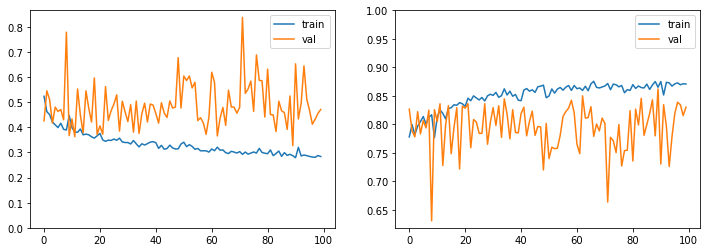

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6415 - accuracy: 0.7197 - precision: 0.9956 - recall: 0.7198 - f1: 0.8197 - specificity: 0.1575 - negative_predictive_value: 0.0174 - matthews_correlation_coefficient: 0.0354 - val_loss: 0.4632 - val_accuracy: 0.7389 - val_precision: 0.9976 - val_recall: 0.7453 - val_f1: 0.8508 - val_specificity: 0.2027 - val_negative_predictive_value: 0.0317 - val_matthews_correlation_coefficient: 0.0655

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06555, saving model to ../models/autoencoders_requirements/washed_out_2020_03_21-00_29_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5838 - accuracy: 0.6597 - precision: 0.9768 - recall: 0.6540 - f1: 0.7531 - specificity: 0.2149 - negative_predictive_value: 0.0344 - matthews_correlation_coefficient: 0.0646 - val_loss: 0.5908 - val_accuracy: 0.6635 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2625 - accuracy: 0.9427 - precision: 0.9987 - recall: 0.9440 - f1: 0.9693 - specificity: 0.2345 - negative_predictive_value: 0.1471 - matthews_correlation_coefficient: 0.1727 - val_loss: 0.3534 - val_accuracy: 0.8716 - val_precision: 0.9970 - val_recall: 0.8764 - val_f1: 0.9318 - val_specificity: 0.1757 - val_negative_predictive_value: 0.0701 - val_matthews_correlation_coefficient: 0.0957

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.15832
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2470 - accuracy: 0.9603 - precision: 0.9987 - recall: 0.9616 - f1: 0.9791 - specificity: 0.2517 - negative_predictive_value: 0.1726 - matthews_correlation_coefficient: 0.1979 - val_loss: 0.1718 - val_accuracy: 0.9714 - val_precision: 0.9974 - val_recall: 0.9745 - val_f1: 0.9856 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1441 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.15832
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1922 - accuracy: 0.9488 - precision: 0.9995 - recall: 0.9490 - f1: 0.9703 - specificity: 0.2586 - negative_predictive_value: 0.1745 - matthews_correlation_coefficient: 0.2013 - val_loss: 0.0963 - val_accuracy: 0.9783 - val_precision: 0.9974 - val_recall: 0.9813 - val_f1: 0.9891 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1577 - val_matthews_correlation_coefficient: 0.1608

Epoch 00030: val_matthews_correlation_coefficient improved from 0.15832 to 0.16080, saving model to ../models/autoencoders_requirements/washed_out_2020_03_21-00_29_50.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2087 - accuracy: 0.9633 - precision: 0.9991 - recall: 0.9641 - f1: 0.9797 - specificity: 0.2138 - negative_predictive_value: 0.1576 - matthews_correlation_coefficient: 0.1764 - val_loss: 0.1269 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1458 - accuracy: 0.9876 - precision: 0.9991 - recall: 0.9885 - f1: 0.9937 - specificity: 0.2310 - negative_predictive_value: 0.2057 - matthews_correlation_coefficient: 0.2142 - val_loss: 0.0985 - val_accuracy: 0.9853 - val_precision: 0.9974 - val_recall: 0.9881 - val_f1: 0.9926 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1622 - val_matthews_correlation_coefficient: 0.1645

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.16451
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1989 - accuracy: 0.9694 - precision: 0.9991 - recall: 0.9703 - f1: 0.9838 - specificity: 0.2621 - negative_predictive_value: 0.2002 - matthews_correlation_coefficient: 0.2220 - val_loss: 0.0941 - val_accuracy: 0.9861 - val_precision: 0.9974 - val_recall: 0.9890 - val_f1: 0.9931 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1622 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.17274
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1465 - accuracy: 0.9805 - precision: 0.9991 - recall: 0.9814 - f1: 0.9899 - specificity: 0.2345 - negative_predictive_value: 0.2002 - matthews_correlation_coefficient: 0.2123 - val_loss: 0.1077 - val_accuracy: 0.9827 - val_precision: 0.9974 - val_recall: 0.9856 - val_f1: 0.9913 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1712 - val_matthews_correlation_coefficient: 0.1690

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.17274
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1595 - accuracy: 0.9794 - precision: 0.9989 - recall: 0.9806 - f1: 0.9887 - specificity: 0.2391 - negative_predictive_value: 0.2241 - matthews_correlation_coefficient: 0.2291 - val_loss: 0.1371 - val_accuracy: 0.9853 - val_precision: 0.9974 - val_recall: 0.9881 - val_f1: 0.9926 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.18096
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1178 - accuracy: 0.9889 - precision: 0.9991 - recall: 0.9898 - f1: 0.9943 - specificity: 0.2207 - negative_predictive_value: 0.1966 - matthews_correlation_coefficient: 0.2058 - val_loss: 0.0923 - val_accuracy: 0.9827 - val_precision: 0.9974 - val_recall: 0.9856 - val_f1: 0.9913 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1577 - val_matthews_correlation_coefficient: 0.1608

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.18096
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1553 - accuracy: 0.9826 - precision: 0.9991 - recall: 0.9835 - f1: 0.9910 - specificity: 0.2276 - negative_predictive_value: 0.1924 - matthews_correlation_coefficient: 0.2047 - val_loss: 0.2206 - val_accuracy: 0.9757 - val_precision: 0.9974 - val_recall: 0.9787 - val_f1: 0.9877 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.18096
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0934 - accuracy: 0.9915 - precision: 0.9991 - recall: 0.9924 - f1: 0.9957 - specificity: 0.2276 - negative_predictive_value: 0.2172 - matthews_correlation_coefficient: 0.2203 - val_loss: 0.0707 - val_accuracy: 0.9844 - val_precision: 0.9974 - val_recall: 0.9872 - val_f1: 0.9922 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1577 - val_matthews_correlation_coefficient: 0.1608

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.18096
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1277 - accuracy: 0.9866 - precision: 0.9991 - recall: 0.9874 - f1: 0.9931 - specificity: 0.2253 - negative_predictive_value: 0.1954 - matthews_correlation_coefficient: 0.2062 - val_loss: 0.1364 - val_accuracy: 0.9731 - val_precision: 0.9974 - val_recall: 0.9762 - val_f1: 0.9865 - val_spe

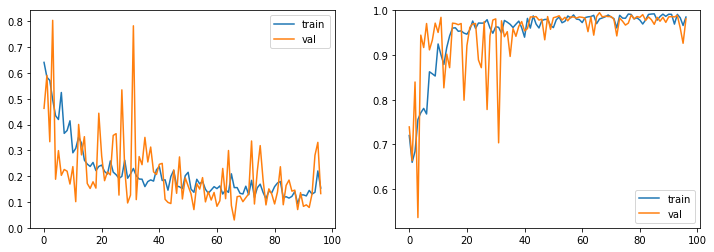

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6614 - accuracy: 0.5894 - precision: 0.9211 - recall: 0.5819 - f1: 0.7004 - specificity: 0.5868 - negative_predictive_value: 0.1064 - matthews_correlation_coefficient: 0.1211 - val_loss: 0.7499 - val_accuracy: 0.4805 - val_precision: 0.9676 - val_recall: 0.4753 - val_f1: 0.6297 - val_specificity: 0.6689 - val_negative_predictive_value: 0.0892 - val_matthews_correlation_coefficient: 0.1039

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10393, saving model to ../models/autoencoders_requirements/pixelation_2020_03_21-00_44_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6291 - accuracy: 0.6388 - precision: 0.9730 - recall: 0.6352 - f1: 0.7580 - specificity: 0.6195 - negative_predictive_value: 0.1262 - matthews_correlation_coefficient: 0.1696 - val_loss: 0.5663 - val_accuracy: 0.6435 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.21425
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5056 - accuracy: 0.7202 - precision: 0.9790 - recall: 0.7181 - f1: 0.8262 - specificity: 0.6771 - negative_predictive_value: 0.1599 - matthews_correlation_coefficient: 0.2375 - val_loss: 0.3357 - val_accuracy: 0.8578 - val_precision: 0.9586 - val_recall: 0.8918 - val_f1: 0.9224 - val_specificity: 0.3820 - val_negative_predictive_value: 0.2412 - val_matthews_correlation_coefficient: 0.2295

Epoch 00015: val_matthews_correlation_coefficient improved from 0.21425 to 0.22949, saving model to ../models/autoencoders_requirements/pixelation_2020_03_21-00_44_14.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5067 - accuracy: 0.7356 - precision: 0.9770 - recall: 0.7366 - f1: 0.8344 - specificity: 0.6544 - negative_predictive_value: 0.1732 - matthews_correlation_coefficient: 0.2426 - val_loss: 0.3903 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4800 - accuracy: 0.7299 - precision: 0.9814 - recall: 0.7271 - f1: 0.8326 - specificity: 0.6741 - negative_predictive_value: 0.1753 - matthews_correlation_coefficient: 0.2574 - val_loss: 0.2620 - val_accuracy: 0.9271 - val_precision: 0.9476 - val_recall: 0.9786 - val_f1: 0.9621 - val_specificity: 0.1851 - val_negative_predictive_value: 0.2748 - val_matthews_correlation_coefficient: 0.1874

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.29143
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5142 - accuracy: 0.7280 - precision: 0.9752 - recall: 0.7279 - f1: 0.8281 - specificity: 0.6776 - negative_predictive_value: 0.1686 - matthews_correlation_coefficient: 0.2466 - val_loss: 0.3790 - val_accuracy: 0.7754 - val_precision: 0.9683 - val_recall: 0.7936 - val_f1: 0.8684 - val_specificity: 0.5712 - val_negative_predictive_value: 0.1890 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4696 - accuracy: 0.7317 - precision: 0.9819 - recall: 0.7287 - f1: 0.8334 - specificity: 0.6678 - negative_predictive_value: 0.1754 - matthews_correlation_coefficient: 0.2551 - val_loss: 0.2912 - val_accuracy: 0.8682 - val_precision: 0.9523 - val_recall: 0.9097 - val_f1: 0.9287 - val_specificity: 0.3036 - val_negative_predictive_value: 0.2369 - val_matthews_correlation_coefficient: 0.1954

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.29143
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4673 - accuracy: 0.7510 - precision: 0.9804 - recall: 0.7496 - f1: 0.8466 - specificity: 0.7317 - negative_predictive_value: 0.1880 - matthews_correlation_coefficient: 0.2825 - val_loss: 0.3102 - val_accuracy: 0.8569 - val_precision: 0.9533 - val_recall: 0.8959 - val_f1: 0.9221 - val_specificity: 0.3360 - val_negative_predictive_value: 0.1996 - val_matthews_correlation_coefficie

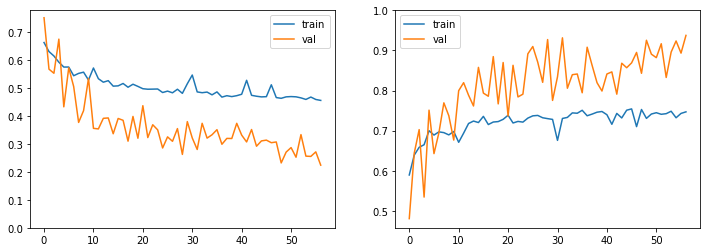

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5849 - accuracy: 0.6221 - precision: 0.9003 - recall: 0.5457 - f1: 0.6636 - specificity: 0.8230 - negative_predictive_value: 0.4076 - matthews_correlation_coefficient: 0.3387 - val_loss: 0.5686 - val_accuracy: 0.6557 - val_precision: 0.8872 - val_recall: 0.6105 - val_f1: 0.7158 - val_specificity: 0.7815 - val_negative_predictive_value: 0.4321 - val_matthews_correlation_coefficient: 0.3522

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35218, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_21-00_52_42.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5707 - accuracy: 0.6367 - precision: 0.8992 - recall: 0.5518 - f1: 0.6739 - specificity: 0.8509 - negative_predictive_value: 0.4329 - matthews_correlation_coefficient: 0.3706 - val_loss: 0.6900 - val_accuracy: 0.5533 - val_preci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5167 - accuracy: 0.7180 - precision: 0.9090 - recall: 0.6814 - f1: 0.7656 - specificity: 0.8046 - negative_predictive_value: 0.5150 - matthews_correlation_coefficient: 0.4520 - val_loss: 0.5489 - val_accuracy: 0.6964 - val_precision: 0.9036 - val_recall: 0.6053 - val_f1: 0.7201 - val_specificity: 0.8667 - val_negative_predictive_value: 0.4701 - val_matthews_correlation_coefficient: 0.4451

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.44912
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5079 - accuracy: 0.7187 - precision: 0.9161 - recall: 0.6776 - f1: 0.7691 - specificity: 0.8300 - negative_predictive_value: 0.5096 - matthews_correlation_coefficient: 0.4627 - val_loss: 0.5142 - val_accuracy: 0.7285 - val_precision: 0.9167 - val_recall: 0.6938 - val_f1: 0.7837 - val_specificity: 0.8203 - val_negative_predictive_value: 0.5031 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.47551
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4732 - accuracy: 0.7579 - precision: 0.9268 - recall: 0.7214 - f1: 0.8045 - specificity: 0.8488 - negative_predictive_value: 0.5548 - matthews_correlation_coefficient: 0.5237 - val_loss: 0.5084 - val_accuracy: 0.7424 - val_precision: 0.9047 - val_recall: 0.7263 - val_f1: 0.8002 - val_specificity: 0.7802 - val_negative_predictive_value: 0.5181 - val_matthews_correlation_coefficient: 0.4613

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.47551
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4754 - accuracy: 0.7534 - precision: 0.9161 - recall: 0.7161 - f1: 0.7957 - specificity: 0.8441 - negative_predictive_value: 0.5565 - matthews_correlation_coefficient: 0.5150 - val_loss: 0.4998 - val_accuracy: 0.7398 - val_precision: 0.9117 - val_recall: 0.7135 - val_f1: 0.7948 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4543 - accuracy: 0.7636 - precision: 0.9297 - recall: 0.7301 - f1: 0.8122 - specificity: 0.8490 - negative_predictive_value: 0.5575 - matthews_correlation_coefficient: 0.5293 - val_loss: 0.4774 - val_accuracy: 0.7589 - val_precision: 0.9034 - val_recall: 0.7517 - val_f1: 0.8158 - val_specificity: 0.7846 - val_negative_predictive_value: 0.5416 - val_matthews_correlation_coefficient: 0.4869

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49048
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4460 - accuracy: 0.7703 - precision: 0.9184 - recall: 0.7370 - f1: 0.8125 - specificity: 0.8372 - negative_predictive_value: 0.5672 - matthews_correlation_coefficient: 0.5278 - val_loss: 0.5276 - val_accuracy: 0.7381 - val_precision: 0.9307 - val_recall: 0.6966 - val_f1: 0.7900 - val_specificity: 0.8475 - val_negative_predictive_value: 0.5144 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.52413
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4275 - accuracy: 0.7892 - precision: 0.9346 - recall: 0.7593 - f1: 0.8334 - specificity: 0.8576 - negative_predictive_value: 0.5917 - matthews_correlation_coefficient: 0.5697 - val_loss: 0.5424 - val_accuracy: 0.7346 - val_precision: 0.9123 - val_recall: 0.6571 - val_f1: 0.7595 - val_specificity: 0.8662 - val_negative_predictive_value: 0.5061 - val_matthews_correlation_coefficient: 0.4933

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.52413
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4259 - accuracy: 0.7887 - precision: 0.9340 - recall: 0.7619 - f1: 0.8349 - specificity: 0.8502 - negative_predictive_value: 0.5859 - matthews_correlation_coefficient: 0.5624 - val_loss: 0.4783 - val_accuracy: 0.7710 - val_precision: 0.9017 - val_recall: 0.7731 - val_f1: 0.8282 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.52413
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4286 - accuracy: 0.7885 - precision: 0.9277 - recall: 0.7564 - f1: 0.8282 - specificity: 0.8652 - negative_predictive_value: 0.5931 - matthews_correlation_coefficient: 0.5686 - val_loss: 0.5820 - val_accuracy: 0.6852 - val_precision: 0.9124 - val_recall: 0.5846 - val_f1: 0.7081 - val_specificity: 0.8843 - val_negative_predictive_value: 0.4614 - val_matthews_correlation_coefficient: 0.4437

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.52413
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4223 - accuracy: 0.7883 - precision: 0.9360 - recall: 0.7624 - f1: 0.8338 - specificity: 0.8561 - negative_predictive_value: 0.5961 - matthews_correlation_coefficient: 0.5717 - val_loss: 0.4560 - val_accuracy: 0.7910 - val_precision: 0.8995 - val_recall: 0.8067 - val_f1: 0.8468 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.52483
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4171 - accuracy: 0.7874 - precision: 0.9408 - recall: 0.7491 - f1: 0.8274 - specificity: 0.8627 - negative_predictive_value: 0.5830 - matthews_correlation_coefficient: 0.5665 - val_loss: 0.5116 - val_accuracy: 0.7441 - val_precision: 0.9140 - val_recall: 0.7195 - val_f1: 0.7998 - val_specificity: 0.8140 - val_negative_predictive_value: 0.5222 - val_matthews_correlation_coefficient: 0.4807

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.52483
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4116 - accuracy: 0.7952 - precision: 0.9382 - recall: 0.7640 - f1: 0.8370 - specificity: 0.8643 - negative_predictive_value: 0.5978 - matthews_correlation_coefficient: 0.5793 - val_loss: 0.4461 - val_accuracy: 0.8014 - val_precision: 0.8675 - val_recall: 0.8613 - val_f1: 0.8613 - val_spe

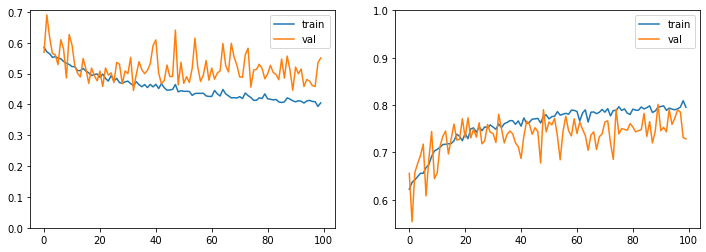

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6508 - accuracy: 0.5633 - precision: 0.8773 - recall: 0.5157 - f1: 0.6331 - specificity: 0.7140 - negative_predictive_value: 0.2849 - matthews_correlation_coefficient: 0.2002 - val_loss: 0.6292 - val_accuracy: 0.5533 - val_precision: 0.8454 - val_recall: 0.4873 - val_f1: 0.6130 - val_specificity: 0.7223 - val_negative_predictive_value: 0.2975 - val_matthews_correlation_coefficient: 0.1998

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19982, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_21-01_07_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6432 - accuracy: 0.5631 - precision: 0.8750 - recall: 0.5023 - f1: 0.6266 - specificity: 0.7472 - negative_predictive_value: 0.3070 - matthews_correlation_coefficient: 0.2108 - val_loss: 0.6866 - val_accuracy: 0.5030 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5941 - accuracy: 0.6659 - precision: 0.8932 - recall: 0.6518 - f1: 0.7466 - specificity: 0.7254 - negative_predictive_value: 0.3793 - matthews_correlation_coefficient: 0.3184 - val_loss: 0.5759 - val_accuracy: 0.6826 - val_precision: 0.8732 - val_recall: 0.6523 - val_f1: 0.7423 - val_specificity: 0.7125 - val_negative_predictive_value: 0.3859 - val_matthews_correlation_coefficient: 0.3335

Epoch 00015: val_matthews_correlation_coefficient improved from 0.32182 to 0.33347, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_21-01_07_26.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5920 - accuracy: 0.6783 - precision: 0.8959 - recall: 0.6654 - f1: 0.7562 - specificity: 0.7228 - negative_predictive_value: 0.3872 - matthews_correlation_coefficient: 0.3298 - val_loss: 0.6965 - val_accuracy: 0.6036 - val_precision: 0.8733 - val_recall: 0.5389 - val_f1: 0.6617 - val_spec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5691 - accuracy: 0.7054 - precision: 0.9038 - recall: 0.7003 - f1: 0.7833 - specificity: 0.7299 - negative_predictive_value: 0.4222 - matthews_correlation_coefficient: 0.3708 - val_loss: 0.6148 - val_accuracy: 0.6496 - val_precision: 0.8842 - val_recall: 0.5972 - val_f1: 0.7068 - val_specificity: 0.7645 - val_negative_predictive_value: 0.3676 - val_matthews_correlation_coefficient: 0.3282

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.33347
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5699 - accuracy: 0.6920 - precision: 0.8954 - recall: 0.6829 - f1: 0.7679 - specificity: 0.7157 - negative_predictive_value: 0.4057 - matthews_correlation_coefficient: 0.3453 - val_loss: 0.4804 - val_accuracy: 0.7658 - val_precision: 0.8185 - val_recall: 0.8403 - val_f1: 0.8269 - val_specificity: 0.4213 - val_negative_predictive_value: 0.4633 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.35629
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5445 - accuracy: 0.7148 - precision: 0.9051 - recall: 0.7104 - f1: 0.7909 - specificity: 0.7385 - negative_predictive_value: 0.4314 - matthews_correlation_coefficient: 0.3858 - val_loss: 0.5583 - val_accuracy: 0.6964 - val_precision: 0.8712 - val_recall: 0.6774 - val_f1: 0.7566 - val_specificity: 0.6952 - val_negative_predictive_value: 0.3987 - val_matthews_correlation_coefficient: 0.3426

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.35629
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5438 - accuracy: 0.7180 - precision: 0.9068 - recall: 0.7075 - f1: 0.7877 - specificity: 0.7423 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.3933 - val_loss: 0.5337 - val_accuracy: 0.7155 - val_precision: 0.8538 - val_recall: 0.7208 - val_f1: 0.7778 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.35629
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5633 - accuracy: 0.6948 - precision: 0.9022 - recall: 0.6829 - f1: 0.7658 - specificity: 0.7286 - negative_predictive_value: 0.4159 - matthews_correlation_coefficient: 0.3600 - val_loss: 0.6435 - val_accuracy: 0.6357 - val_precision: 0.8864 - val_recall: 0.5757 - val_f1: 0.6917 - val_specificity: 0.7763 - val_negative_predictive_value: 0.3572 - val_matthews_correlation_coefficient: 0.3191

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.35629
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5381 - accuracy: 0.7176 - precision: 0.9134 - recall: 0.7034 - f1: 0.7880 - specificity: 0.7490 - negative_predictive_value: 0.4348 - matthews_correlation_coefficient: 0.3957 - val_loss: 0.6394 - val_accuracy: 0.6349 - val_precision: 0.8716 - val_recall: 0.5856 - val_f1: 0.6964 - val_spe

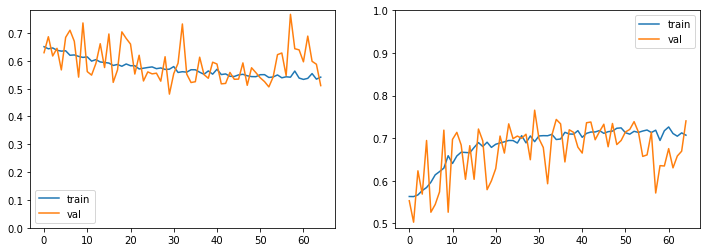

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5063 - accuracy: 0.7412 - precision: 0.7942 - recall: 0.7416 - f1: 0.7511 - specificity: 0.7398 - negative_predictive_value: 0.6817 - matthews_correlation_coefficient: 0.4898 - val_loss: 0.4016 - val_accuracy: 0.8265 - val_precision: 0.8158 - val_recall: 0.9278 - val_f1: 0.8665 - val_specificity: 0.6520 - val_negative_predictive_value: 0.8328 - val_matthews_correlation_coefficient: 0.6124

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.61237, saving model to ../models/autoencoders_requirements/varied_background_2020_03_21-01_17_05.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4384 - accuracy: 0.7848 - precision: 0.8337 - recall: 0.8039 - f1: 0.8074 - specificity: 0.7613 - negative_predictive_value: 0.7397 - matthews_correlation_coefficient: 0.5697 - val_loss: 0.4065 - val_accuracy: 0.8040 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.66982
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3641 - accuracy: 0.8358 - precision: 0.8632 - recall: 0.8569 - f1: 0.8553 - specificity: 0.8016 - negative_predictive_value: 0.7974 - matthews_correlation_coefficient: 0.6605 - val_loss: 0.3814 - val_accuracy: 0.8361 - val_precision: 0.9309 - val_recall: 0.7918 - val_f1: 0.8523 - val_specificity: 0.8847 - val_negative_predictive_value: 0.7193 - val_matthews_correlation_coefficient: 0.6628

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.66982
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3567 - accuracy: 0.8451 - precision: 0.8775 - recall: 0.8689 - f1: 0.8673 - specificity: 0.8163 - negative_predictive_value: 0.7983 - matthews_correlation_coefficient: 0.6813 - val_loss: 0.3394 - val_accuracy: 0.8534 - val_precision: 0.8940 - val_recall: 0.8658 - val_f1: 0.8773 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3330 - accuracy: 0.8531 - precision: 0.8857 - recall: 0.8708 - f1: 0.8735 - specificity: 0.8290 - negative_predictive_value: 0.8057 - matthews_correlation_coefficient: 0.6966 - val_loss: 0.3189 - val_accuracy: 0.8638 - val_precision: 0.8910 - val_recall: 0.8868 - val_f1: 0.8865 - val_specificity: 0.8069 - val_negative_predictive_value: 0.8055 - val_matthews_correlation_coefficient: 0.6948

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.69670
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3301 - accuracy: 0.8599 - precision: 0.8838 - recall: 0.8735 - f1: 0.8753 - specificity: 0.8362 - negative_predictive_value: 0.8194 - matthews_correlation_coefficient: 0.7076 - val_loss: 0.3345 - val_accuracy: 0.8586 - val_precision: 0.9178 - val_recall: 0.8451 - val_f1: 0.8773 - val_specificity: 0.8560 - val_negative_predictive_value: 0.7665 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.70703 to 0.71884, saving model to ../models/autoencoders_requirements/varied_background_2020_03_21-01_17_05.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3156 - accuracy: 0.8625 - precision: 0.8989 - recall: 0.8735 - f1: 0.8805 - specificity: 0.8505 - negative_predictive_value: 0.8107 - matthews_correlation_coefficient: 0.7180 - val_loss: 0.3196 - val_accuracy: 0.8560 - val_precision: 0.8303 - val_recall: 0.9640 - val_f1: 0.8902 - val_specificity: 0.6721 - val_negative_predictive_value: 0.9018 - val_matthews_correlation_coefficient: 0.6808

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.71884
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3204 - accuracy: 0.8651 - precision: 0.8941 - recall: 0.8867 - f1: 0.8855 - specificity: 0.8371 - negative_predictive_value: 0.8258 - matthews_correlation_coefficient: 0.7210 - val_loss: 0.3

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3053 - accuracy: 0.8655 - precision: 0.8945 - recall: 0.8825 - f1: 0.8835 - specificity: 0.8361 - negative_predictive_value: 0.8291 - matthews_correlation_coefficient: 0.7222 - val_loss: 0.3010 - val_accuracy: 0.8742 - val_precision: 0.8525 - val_recall: 0.9625 - val_f1: 0.9021 - val_specificity: 0.7186 - val_negative_predictive_value: 0.9061 - val_matthews_correlation_coefficient: 0.7176

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.74317
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3235 - accuracy: 0.8616 - precision: 0.8894 - recall: 0.8828 - f1: 0.8792 - specificity: 0.8363 - negative_predictive_value: 0.8271 - matthews_correlation_coefficient: 0.7188 - val_loss: 0.3106 - val_accuracy: 0.8682 - val_precision: 0.8675 - val_recall: 0.9261 - val_f1: 0.8939 - val_specificity: 0.7532 - val_negative_predictive_value: 0.8573 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.75106
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2932 - accuracy: 0.8764 - precision: 0.8929 - recall: 0.8911 - f1: 0.8882 - specificity: 0.8567 - negative_predictive_value: 0.8457 - matthews_correlation_coefficient: 0.7442 - val_loss: 0.2783 - val_accuracy: 0.8864 - val_precision: 0.9077 - val_recall: 0.9063 - val_f1: 0.9046 - val_specificity: 0.8319 - val_negative_predictive_value: 0.8377 - val_matthews_correlation_coefficient: 0.7415

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.75106
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3051 - accuracy: 0.8720 - precision: 0.8938 - recall: 0.8936 - f1: 0.8896 - specificity: 0.8468 - negative_predictive_value: 0.8328 - matthews_correlation_coefficient: 0.7346 - val_loss: 0.2955 - val_accuracy: 0.8803 - val_precision: 0.9151 - val_recall: 0.8892 - val_f1: 0.8994 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.75568
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2809 - accuracy: 0.8846 - precision: 0.9082 - recall: 0.9058 - f1: 0.9034 - specificity: 0.8614 - negative_predictive_value: 0.8531 - matthews_correlation_coefficient: 0.7634 - val_loss: 0.2914 - val_accuracy: 0.8829 - val_precision: 0.8866 - val_recall: 0.9282 - val_f1: 0.9052 - val_specificity: 0.7871 - val_negative_predictive_value: 0.8582 - val_matthews_correlation_coefficient: 0.7294

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.75568
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2827 - accuracy: 0.8824 - precision: 0.9016 - recall: 0.8936 - f1: 0.8937 - specificity: 0.8614 - negative_predictive_value: 0.8549 - matthews_correlation_coefficient: 0.7567 - val_loss: 0.2874 - val_accuracy: 0.8907 - val_precision: 0.8989 - val_recall: 0.9285 - val_f1: 0.9116 - val_spe

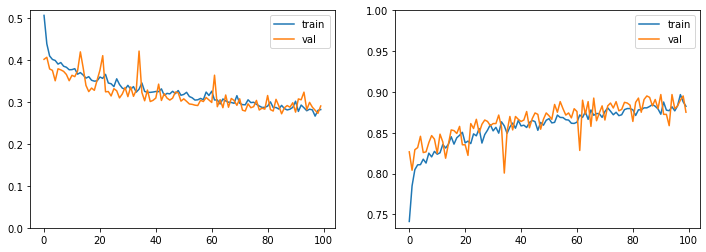

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5710 - accuracy: 0.7067 - precision: 0.9277 - recall: 0.6856 - f1: 0.7810 - specificity: 0.7848 - negative_predictive_value: 0.3689 - matthews_correlation_coefficient: 0.3763 - val_loss: 0.4586 - val_accuracy: 0.7251 - val_precision: 0.9386 - val_recall: 0.7116 - val_f1: 0.8067 - val_specificity: 0.7989 - val_negative_predictive_value: 0.4032 - val_matthews_correlation_coefficient: 0.4159

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.41592, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_21-01_31_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5502 - accuracy: 0.7050 - precision: 0.9420 - recall: 0.6705 - f1: 0.7786 - specificity: 0.8273 - negative_predictive_value: 0.3947 - matthews_correlation_coefficient: 0.4072 - val_loss: 0.5628 - val_accuracy: 0.7008 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5240 - accuracy: 0.7128 - precision: 0.9468 - recall: 0.6787 - f1: 0.7878 - specificity: 0.8501 - negative_predictive_value: 0.3968 - matthews_correlation_coefficient: 0.4220 - val_loss: 0.5260 - val_accuracy: 0.7103 - val_precision: 0.9590 - val_recall: 0.6758 - val_f1: 0.7895 - val_specificity: 0.8599 - val_negative_predictive_value: 0.3934 - val_matthews_correlation_coefficient: 0.4326

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.44238
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5270 - accuracy: 0.7093 - precision: 0.9456 - recall: 0.6751 - f1: 0.7847 - specificity: 0.8521 - negative_predictive_value: 0.4030 - matthews_correlation_coefficient: 0.4255 - val_loss: 0.5459 - val_accuracy: 0.7016 - val_precision: 0.9633 - val_recall: 0.6610 - val_f1: 0.7801 - val_specificity: 0.8799 - val_negative_predictive_value: 0.3902 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5237 - accuracy: 0.7102 - precision: 0.9469 - recall: 0.6757 - f1: 0.7849 - specificity: 0.8498 - negative_predictive_value: 0.4002 - matthews_correlation_coefficient: 0.4238 - val_loss: 0.5109 - val_accuracy: 0.7173 - val_precision: 0.9566 - val_recall: 0.6862 - val_f1: 0.7956 - val_specificity: 0.8546 - val_negative_predictive_value: 0.3993 - val_matthews_correlation_coefficient: 0.4369

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.44238
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5199 - accuracy: 0.7150 - precision: 0.9488 - recall: 0.6831 - f1: 0.7903 - specificity: 0.8582 - negative_predictive_value: 0.4117 - matthews_correlation_coefficient: 0.4366 - val_loss: 0.5792 - val_accuracy: 0.6860 - val_precision: 0.9663 - val_recall: 0.6381 - val_f1: 0.7642 - val_specificity: 0.8913 - val_negative_predictive_value: 0.3775 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44562
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5112 - accuracy: 0.7161 - precision: 0.9499 - recall: 0.6803 - f1: 0.7890 - specificity: 0.8538 - negative_predictive_value: 0.4058 - matthews_correlation_coefficient: 0.4323 - val_loss: 0.5312 - val_accuracy: 0.7051 - val_precision: 0.9623 - val_recall: 0.6659 - val_f1: 0.7836 - val_specificity: 0.8745 - val_negative_predictive_value: 0.3904 - val_matthews_correlation_coefficient: 0.4347

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.44562
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5078 - accuracy: 0.7158 - precision: 0.9505 - recall: 0.6778 - f1: 0.7865 - specificity: 0.8704 - negative_predictive_value: 0.4058 - matthews_correlation_coefficient: 0.4402 - val_loss: 0.5193 - val_accuracy: 0.7251 - val_precision: 0.9571 - val_recall: 0.6958 - val_f1: 0.8025 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5017 - accuracy: 0.7189 - precision: 0.9519 - recall: 0.6821 - f1: 0.7915 - specificity: 0.8740 - negative_predictive_value: 0.4141 - matthews_correlation_coefficient: 0.4469 - val_loss: 0.5539 - val_accuracy: 0.6964 - val_precision: 0.9658 - val_recall: 0.6516 - val_f1: 0.7740 - val_specificity: 0.8859 - val_negative_predictive_value: 0.3846 - val_matthews_correlation_coefficient: 0.4320

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45105
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5062 - accuracy: 0.7176 - precision: 0.9516 - recall: 0.6817 - f1: 0.7911 - specificity: 0.8661 - negative_predictive_value: 0.4143 - matthews_correlation_coefficient: 0.4451 - val_loss: 0.5180 - val_accuracy: 0.7199 - val_precision: 0.9578 - val_recall: 0.6878 - val_f1: 0.7976 - val_specificity: 0.8569 - val_negative_predictive_value: 0.4006 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.45175
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5010 - accuracy: 0.7217 - precision: 0.9502 - recall: 0.6880 - f1: 0.7949 - specificity: 0.8591 - negative_predictive_value: 0.4103 - matthews_correlation_coefficient: 0.4400 - val_loss: 0.5600 - val_accuracy: 0.7129 - val_precision: 0.9628 - val_recall: 0.6752 - val_f1: 0.7905 - val_specificity: 0.8745 - val_negative_predictive_value: 0.3967 - val_matthews_correlation_coefficient: 0.4427

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.45175
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5004 - accuracy: 0.7178 - precision: 0.9529 - recall: 0.6809 - f1: 0.7906 - specificity: 0.8678 - negative_predictive_value: 0.4139 - matthews_correlation_coefficient: 0.4453 - val_loss: 0.5286 - val_accuracy: 0.7121 - val_precision: 0.9597 - val_recall: 0.6761 - val_f1: 0.7896 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.45195
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4898 - accuracy: 0.7206 - precision: 0.9528 - recall: 0.6842 - f1: 0.7933 - specificity: 0.8655 - negative_predictive_value: 0.4068 - matthews_correlation_coefficient: 0.4396 - val_loss: 0.4996 - val_accuracy: 0.7199 - val_precision: 0.9591 - val_recall: 0.6868 - val_f1: 0.7970 - val_specificity: 0.8639 - val_negative_predictive_value: 0.4021 - val_matthews_correlation_coefficient: 0.4442

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.45195
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4944 - accuracy: 0.7271 - precision: 0.9513 - recall: 0.6959 - f1: 0.7999 - specificity: 0.8554 - negative_predictive_value: 0.4160 - matthews_correlation_coefficient: 0.4454 - val_loss: 0.5868 - val_accuracy: 0.7008 - val_precision: 0.9630 - val_recall: 0.6594 - val_f1: 0.7789 - val_spe

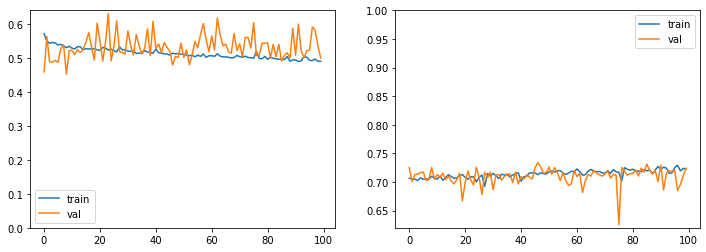

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5595 - accuracy: 0.7139 - precision: 0.8155 - recall: 0.7083 - f1: 0.7417 - specificity: 0.7114 - negative_predictive_value: 0.5638 - matthews_correlation_coefficient: 0.4107 - val_loss: 0.5495 - val_accuracy: 0.7199 - val_precision: 0.8394 - val_recall: 0.6879 - val_f1: 0.7515 - val_specificity: 0.7605 - val_negative_predictive_value: 0.5448 - val_matthews_correlation_coefficient: 0.4136

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.41357, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_21-01_46_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5003 - accuracy: 0.7855 - precision: 0.8697 - recall: 0.8196 - f1: 0.8390 - specificity: 0.7283 - negative_predictive_value: 0.6452 - matthews_correlation_coefficient: 0.5290 - val_loss: 0.4663 - val_accuracy: 0.7971 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4138 - accuracy: 0.8380 - precision: 0.8963 - recall: 0.8549 - f1: 0.8724 - specificity: 0.7988 - negative_predictive_value: 0.7112 - matthews_correlation_coefficient: 0.6299 - val_loss: 0.4253 - val_accuracy: 0.8395 - val_precision: 0.8769 - val_recall: 0.8385 - val_f1: 0.8543 - val_specificity: 0.8006 - val_negative_predictive_value: 0.7278 - val_matthews_correlation_coefficient: 0.6202

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.63411
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4163 - accuracy: 0.8367 - precision: 0.8990 - recall: 0.8588 - f1: 0.8745 - specificity: 0.7816 - negative_predictive_value: 0.7106 - matthews_correlation_coefficient: 0.6249 - val_loss: 0.3796 - val_accuracy: 0.8586 - val_precision: 0.8664 - val_recall: 0.8827 - val_f1: 0.8720 - val_specificity: 0.7625 - val_negative_predictive_value: 0.7874 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient improved from 0.64855 to 0.67177, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_21-01_46_35.h5
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3773 - accuracy: 0.8566 - precision: 0.9092 - recall: 0.8808 - f1: 0.8917 - specificity: 0.8036 - negative_predictive_value: 0.7375 - matthews_correlation_coefficient: 0.6655 - val_loss: 0.4507 - val_accuracy: 0.8257 - val_precision: 0.8766 - val_recall: 0.8147 - val_f1: 0.8419 - val_specificity: 0.8086 - val_negative_predictive_value: 0.6971 - val_matthews_correlation_coefficient: 0.5967

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.67177
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3848 - accuracy: 0.8460 - precision: 0.9110 - recall: 0.8642 - f1: 0.8839 - specificity: 0.8094 - negative_predictive_value: 0.7292 - matthews_correlation_coefficient: 0.6554 - val_lo

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3629 - accuracy: 0.8575 - precision: 0.9148 - recall: 0.8819 - f1: 0.8953 - specificity: 0.8124 - negative_predictive_value: 0.7527 - matthews_correlation_coefficient: 0.6787 - val_loss: 0.3629 - val_accuracy: 0.8569 - val_precision: 0.8781 - val_recall: 0.8640 - val_f1: 0.8683 - val_specificity: 0.7957 - val_negative_predictive_value: 0.7695 - val_matthews_correlation_coefficient: 0.6518

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.67273
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3604 - accuracy: 0.8633 - precision: 0.9102 - recall: 0.8877 - f1: 0.8961 - specificity: 0.8050 - negative_predictive_value: 0.7585 - matthews_correlation_coefficient: 0.6811 - val_loss: 0.5082 - val_accuracy: 0.7762 - val_precision: 0.8782 - val_recall: 0.7372 - val_f1: 0.7980 - val_specificity: 0.8270 - val_negative_predictive_value: 0.6099 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3471 - accuracy: 0.8636 - precision: 0.9228 - recall: 0.8757 - f1: 0.8959 - specificity: 0.8265 - negative_predictive_value: 0.7463 - matthews_correlation_coefficient: 0.6856 - val_loss: 0.3838 - val_accuracy: 0.8474 - val_precision: 0.8752 - val_recall: 0.8528 - val_f1: 0.8614 - val_specificity: 0.7897 - val_negative_predictive_value: 0.7450 - val_matthews_correlation_coefficient: 0.6297

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.67273
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3466 - accuracy: 0.8685 - precision: 0.9183 - recall: 0.8903 - f1: 0.9015 - specificity: 0.8251 - negative_predictive_value: 0.7666 - matthews_correlation_coefficient: 0.6983 - val_loss: 0.5094 - val_accuracy: 0.7832 - val_precision: 0.8737 - val_recall: 0.7507 - val_f1: 0.8046 - val_specificity: 0.8160 - val_negative_predictive_value: 0.6227 - val_matthews_correlation_coefficie

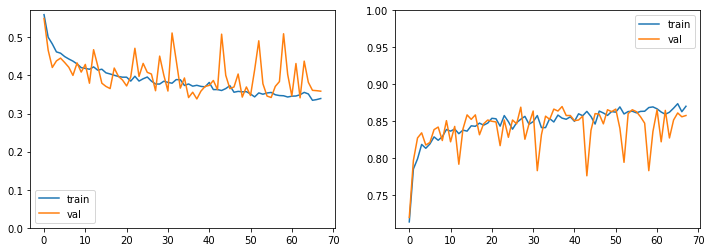

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6441 - accuracy: 0.5377 - precision: 0.8923 - recall: 0.4646 - f1: 0.5932 - specificity: 0.7871 - negative_predictive_value: 0.2955 - matthews_correlation_coefficient: 0.2218 - val_loss: 0.6633 - val_accuracy: 0.4883 - val_precision: 0.8848 - val_recall: 0.3577 - val_f1: 0.5043 - val_specificity: 0.8574 - val_negative_predictive_value: 0.2876 - val_matthews_correlation_coefficient: 0.2179

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21792, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_21-01_56_43.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6291 - accuracy: 0.5399 - precision: 0.9066 - recall: 0.4512 - f1: 0.5933 - specificity: 0.8297 - negative_predictive_value: 0.3104 - matthews_correlation_coefficient: 0.2453 - val_loss: 0.6771 - val_accuracy: 0.4848 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5932 - accuracy: 0.6293 - precision: 0.9036 - recall: 0.5896 - f1: 0.7041 - specificity: 0.7678 - negative_predictive_value: 0.3613 - matthews_correlation_coefficient: 0.3075 - val_loss: 0.6670 - val_accuracy: 0.5247 - val_precision: 0.9015 - val_recall: 0.4005 - val_f1: 0.5500 - val_specificity: 0.8678 - val_negative_predictive_value: 0.3046 - val_matthews_correlation_coefficient: 0.2603

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32281
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5812 - accuracy: 0.6408 - precision: 0.9146 - recall: 0.5949 - f1: 0.7096 - specificity: 0.7935 - negative_predictive_value: 0.3755 - matthews_correlation_coefficient: 0.3350 - val_loss: 0.5824 - val_accuracy: 0.6401 - val_precision: 0.8780 - val_recall: 0.5805 - val_f1: 0.6950 - val_specificity: 0.7612 - val_negative_predictive_value: 0.3566 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36730
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5508 - accuracy: 0.6725 - precision: 0.9051 - recall: 0.6342 - f1: 0.7398 - specificity: 0.7826 - negative_predictive_value: 0.3936 - matthews_correlation_coefficient: 0.3572 - val_loss: 0.5382 - val_accuracy: 0.7016 - val_precision: 0.8968 - val_recall: 0.7051 - val_f1: 0.7862 - val_specificity: 0.6971 - val_negative_predictive_value: 0.4039 - val_matthews_correlation_coefficient: 0.3465

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.36730
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5637 - accuracy: 0.6521 - precision: 0.9069 - recall: 0.6130 - f1: 0.7226 - specificity: 0.7742 - negative_predictive_value: 0.3812 - matthews_correlation_coefficient: 0.3332 - val_loss: 0.5759 - val_accuracy: 0.6479 - val_precision: 0.9237 - val_recall: 0.6033 - val_f1: 0.7259 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37580
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5367 - accuracy: 0.6918 - precision: 0.9165 - recall: 0.6639 - f1: 0.7620 - specificity: 0.7913 - negative_predictive_value: 0.4209 - matthews_correlation_coefficient: 0.3894 - val_loss: 0.4835 - val_accuracy: 0.7528 - val_precision: 0.8748 - val_recall: 0.8035 - val_f1: 0.8349 - val_specificity: 0.5784 - val_negative_predictive_value: 0.4539 - val_matthews_correlation_coefficient: 0.3526

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.37580
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5338 - accuracy: 0.6892 - precision: 0.9190 - recall: 0.6548 - f1: 0.7585 - specificity: 0.8036 - negative_predictive_value: 0.4129 - matthews_correlation_coefficient: 0.3881 - val_loss: 0.5037 - val_accuracy: 0.7259 - val_precision: 0.8845 - val_recall: 0.7529 - val_f1: 0.8109 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.37580
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5240 - accuracy: 0.6946 - precision: 0.9136 - recall: 0.6583 - f1: 0.7603 - specificity: 0.8137 - negative_predictive_value: 0.4189 - matthews_correlation_coefficient: 0.3951 - val_loss: 0.5898 - val_accuracy: 0.6748 - val_precision: 0.9129 - val_recall: 0.6502 - val_f1: 0.7560 - val_specificity: 0.7682 - val_negative_predictive_value: 0.3856 - val_matthews_correlation_coefficient: 0.3521

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.37580
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5154 - accuracy: 0.7000 - precision: 0.9111 - recall: 0.6691 - f1: 0.7649 - specificity: 0.7837 - negative_predictive_value: 0.4213 - matthews_correlation_coefficient: 0.3853 - val_loss: 0.5690 - val_accuracy: 0.6774 - val_precision: 0.9351 - val_recall: 0.6361 - val_f1: 0.7528 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5170 - accuracy: 0.7043 - precision: 0.9113 - recall: 0.6759 - f1: 0.7706 - specificity: 0.7765 - negative_predictive_value: 0.4279 - matthews_correlation_coefficient: 0.3968 - val_loss: 0.5397 - val_accuracy: 0.7008 - val_precision: 0.8940 - val_recall: 0.7051 - val_f1: 0.7851 - val_specificity: 0.6948 - val_negative_predictive_value: 0.4022 - val_matthews_correlation_coefficient: 0.3428

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.39182
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5110 - accuracy: 0.7115 - precision: 0.9218 - recall: 0.6880 - f1: 0.7819 - specificity: 0.8115 - negative_predictive_value: 0.4436 - matthews_correlation_coefficient: 0.4229 - val_loss: 0.5149 - val_accuracy: 0.7303 - val_precision: 0.9033 - val_recall: 0.7381 - val_f1: 0.8095 - val_specificity: 0.7065 - val_negative_predictive_value: 0.4342 - val_matthews_correlation_coefficie


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.39576
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5033 - accuracy: 0.7137 - precision: 0.9162 - recall: 0.6919 - f1: 0.7814 - specificity: 0.7933 - negative_predictive_value: 0.4361 - matthews_correlation_coefficient: 0.4123 - val_loss: 0.5549 - val_accuracy: 0.7346 - val_precision: 0.8406 - val_recall: 0.8214 - val_f1: 0.8284 - val_specificity: 0.4474 - val_negative_predictive_value: 0.4202 - val_matthews_correlation_coefficient: 0.2633

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.39576
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5081 - accuracy: 0.7113 - precision: 0.9178 - recall: 0.6792 - f1: 0.7738 - specificity: 0.8084 - negative_predictive_value: 0.4421 - matthews_correlation_coefficient: 0.4149 - val_loss: 0.5104 - val_accuracy: 0.7259 - val_precision: 0.8821 - val_recall: 0.7560 - val_f1: 0.8109 - val_spe

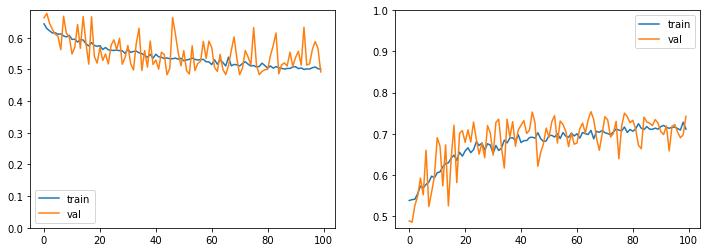

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5089 - accuracy: 0.7310 - precision: 0.8435 - recall: 0.7053 - f1: 0.7580 - specificity: 0.7871 - negative_predictive_value: 0.6264 - matthews_correlation_coefficient: 0.4816 - val_loss: 0.5281 - val_accuracy: 0.7277 - val_precision: 0.8949 - val_recall: 0.5937 - val_f1: 0.7087 - val_specificity: 0.9187 - val_negative_predictive_value: 0.6067 - val_matthews_correlation_coefficient: 0.5057

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.50568, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_21-02_11_38.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4620 - accuracy: 0.7629 - precision: 0.8681 - recall: 0.7137 - f1: 0.7790 - specificity: 0.8308 - negative_predictive_value: 0.6461 - matthews_correlation_coefficient: 0.5286 - val_loss: 0.5038 - val_accuracy: 0.7372 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.61735
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4195 - accuracy: 0.8007 - precision: 0.8896 - recall: 0.7752 - f1: 0.8228 - specificity: 0.8520 - negative_predictive_value: 0.7109 - matthews_correlation_coefficient: 0.6129 - val_loss: 0.4521 - val_accuracy: 0.7962 - val_precision: 0.8052 - val_recall: 0.8230 - val_f1: 0.8101 - val_specificity: 0.7293 - val_negative_predictive_value: 0.7495 - val_matthews_correlation_coefficient: 0.5530

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.61735
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4158 - accuracy: 0.7998 - precision: 0.8892 - recall: 0.7694 - f1: 0.8201 - specificity: 0.8460 - negative_predictive_value: 0.6941 - matthews_correlation_coefficient: 0.6004 - val_loss: 0.4324 - val_accuracy: 0.8118 - val_precision: 0.8841 - val_recall: 0.7507 - val_f1: 0.8089 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4007 - accuracy: 0.8167 - precision: 0.8939 - recall: 0.7978 - f1: 0.8403 - specificity: 0.8443 - negative_predictive_value: 0.7196 - matthews_correlation_coefficient: 0.6271 - val_loss: 0.4107 - val_accuracy: 0.8439 - val_precision: 0.8734 - val_recall: 0.8171 - val_f1: 0.8418 - val_specificity: 0.8551 - val_negative_predictive_value: 0.7739 - val_matthews_correlation_coefficient: 0.6592

Epoch 00029: val_matthews_correlation_coefficient improved from 0.64576 to 0.65923, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_21-02_11_38.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3963 - accuracy: 0.8171 - precision: 0.8973 - recall: 0.7970 - f1: 0.8397 - specificity: 0.8562 - negative_predictive_value: 0.7312 - matthews_correlation_coefficient: 0.6402 - val_loss: 0.4320 - val_accuracy: 0.8109 - val_precision: 0.7894 - val_recall: 0.8752 - val_f1: 0.8268 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3856 - accuracy: 0.8265 - precision: 0.8978 - recall: 0.8103 - f1: 0.8477 - specificity: 0.8560 - negative_predictive_value: 0.7432 - matthews_correlation_coefficient: 0.6531 - val_loss: 0.3931 - val_accuracy: 0.8404 - val_precision: 0.8887 - val_recall: 0.7947 - val_f1: 0.8363 - val_specificity: 0.8776 - val_negative_predictive_value: 0.7544 - val_matthews_correlation_coefficient: 0.6571

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.66791
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3824 - accuracy: 0.8341 - precision: 0.8993 - recall: 0.8281 - f1: 0.8576 - specificity: 0.8549 - negative_predictive_value: 0.7556 - matthews_correlation_coefficient: 0.6681 - val_loss: 0.4034 - val_accuracy: 0.8343 - val_precision: 0.8261 - val_recall: 0.8608 - val_f1: 0.8405 - val_specificity: 0.7635 - val_negative_predictive_value: 0.8097 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.67516
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3594 - accuracy: 0.8479 - precision: 0.9064 - recall: 0.8405 - f1: 0.8696 - specificity: 0.8594 - negative_predictive_value: 0.7659 - matthews_correlation_coefficient: 0.6853 - val_loss: 0.3851 - val_accuracy: 0.8369 - val_precision: 0.8816 - val_recall: 0.7950 - val_f1: 0.8331 - val_specificity: 0.8691 - val_negative_predictive_value: 0.7567 - val_matthews_correlation_coefficient: 0.6507

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.67516
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3627 - accuracy: 0.8425 - precision: 0.9031 - recall: 0.8334 - f1: 0.8637 - specificity: 0.8542 - negative_predictive_value: 0.7596 - matthews_correlation_coefficient: 0.6745 - val_loss: 0.4089 - val_accuracy: 0.8378 - val_precision: 0.8248 - val_recall: 0.8679 - val_f1: 0.8437 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.67862
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3635 - accuracy: 0.8416 - precision: 0.8985 - recall: 0.8409 - f1: 0.8644 - specificity: 0.8454 - negative_predictive_value: 0.7637 - matthews_correlation_coefficient: 0.6735 - val_loss: 0.3858 - val_accuracy: 0.8534 - val_precision: 0.8609 - val_recall: 0.8500 - val_f1: 0.8532 - val_specificity: 0.8260 - val_negative_predictive_value: 0.8061 - val_matthews_correlation_coefficient: 0.6710

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.67862
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3519 - accuracy: 0.8449 - precision: 0.8988 - recall: 0.8439 - f1: 0.8661 - specificity: 0.8418 - negative_predictive_value: 0.7739 - matthews_correlation_coefficient: 0.6803 - val_loss: 0.3805 - val_accuracy: 0.8439 - val_precision: 0.8753 - val_recall: 0.8145 - val_f1: 0.8413 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3493 - accuracy: 0.8488 - precision: 0.8954 - recall: 0.8417 - f1: 0.8633 - specificity: 0.8576 - negative_predictive_value: 0.7810 - matthews_correlation_coefficient: 0.6887 - val_loss: 0.4021 - val_accuracy: 0.8369 - val_precision: 0.8992 - val_recall: 0.7783 - val_f1: 0.8313 - val_specificity: 0.8923 - val_negative_predictive_value: 0.7426 - val_matthews_correlation_coefficient: 0.6555

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.68006
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3485 - accuracy: 0.8501 - precision: 0.9039 - recall: 0.8443 - f1: 0.8684 - specificity: 0.8624 - negative_predictive_value: 0.7704 - matthews_correlation_coefficient: 0.6913 - val_loss: 0.3634 - val_accuracy: 0.8543 - val_precision: 0.8738 - val_recall: 0.8359 - val_f1: 0.8520 - val_specificity: 0.8525 - val_negative_predictive_value: 0.7928 - val_matthews_correlation_coefficie

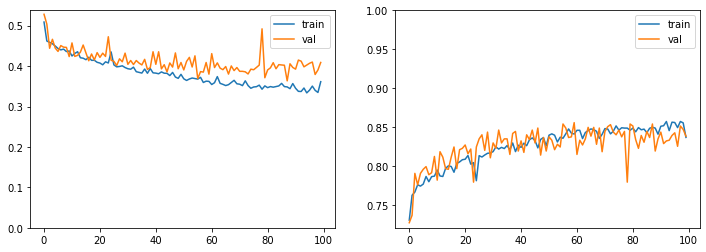

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6411 - accuracy: 0.6074 - precision: 0.5693 - recall: 0.6172 - f1: 0.5669 - specificity: 0.5985 - negative_predictive_value: 0.6657 - matthews_correlation_coefficient: 0.2312 - val_loss: 0.6321 - val_accuracy: 0.6427 - val_precision: 0.6098 - val_recall: 0.6750 - val_f1: 0.6335 - val_specificity: 0.6095 - val_negative_predictive_value: 0.6708 - val_matthews_correlation_coefficient: 0.2824

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28240, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_21-02_26_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6175 - accuracy: 0.6421 - precision: 0.6174 - recall: 0.6648 - f1: 0.6148 - specificity: 0.6343 - negative_predictive_value: 0.7019 - matthews_correlation_coefficient: 0.3096 - val_loss: 0.6201 - val_accuracy: 0.6565 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5452 - accuracy: 0.7189 - precision: 0.6875 - recall: 0.6999 - f1: 0.6816 - specificity: 0.7277 - negative_predictive_value: 0.7444 - matthews_correlation_coefficient: 0.4362 - val_loss: 0.5678 - val_accuracy: 0.6956 - val_precision: 0.6564 - val_recall: 0.7378 - val_f1: 0.6895 - val_specificity: 0.6468 - val_negative_predictive_value: 0.7226 - val_matthews_correlation_coefficient: 0.3817

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39267
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5387 - accuracy: 0.7312 - precision: 0.6990 - recall: 0.7175 - f1: 0.6985 - specificity: 0.7457 - negative_predictive_value: 0.7581 - matthews_correlation_coefficient: 0.4615 - val_loss: 0.5891 - val_accuracy: 0.6964 - val_precision: 0.6412 - val_recall: 0.8189 - val_f1: 0.7130 - val_specificity: 0.5819 - val_negative_predictive_value: 0.7652 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5006 - accuracy: 0.7601 - precision: 0.7356 - recall: 0.7566 - f1: 0.7366 - specificity: 0.7681 - negative_predictive_value: 0.7923 - matthews_correlation_coefficient: 0.5260 - val_loss: 0.5395 - val_accuracy: 0.7129 - val_precision: 0.7012 - val_recall: 0.6790 - val_f1: 0.6833 - val_specificity: 0.7306 - val_negative_predictive_value: 0.7076 - val_matthews_correlation_coefficient: 0.4090

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43335
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5000 - accuracy: 0.7557 - precision: 0.7246 - recall: 0.7505 - f1: 0.7276 - specificity: 0.7636 - negative_predictive_value: 0.7867 - matthews_correlation_coefficient: 0.5124 - val_loss: 0.5354 - val_accuracy: 0.7233 - val_precision: 0.7006 - val_recall: 0.7256 - val_f1: 0.7067 - val_specificity: 0.7118 - val_negative_predictive_value: 0.7301 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.44395
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4875 - accuracy: 0.7662 - precision: 0.7320 - recall: 0.7633 - f1: 0.7396 - specificity: 0.7621 - negative_predictive_value: 0.7908 - matthews_correlation_coefficient: 0.5238 - val_loss: 0.5296 - val_accuracy: 0.7294 - val_precision: 0.7192 - val_recall: 0.7097 - val_f1: 0.7073 - val_specificity: 0.7366 - val_negative_predictive_value: 0.7253 - val_matthews_correlation_coefficient: 0.4452

Epoch 00044: val_matthews_correlation_coefficient improved from 0.44395 to 0.44521, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_21-02_26_26.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4884 - accuracy: 0.7625 - precision: 0.7244 - recall: 0.7629 - f1: 0.7336 - specificity: 0.7657 - negative_predictive_value: 0.8010 - matthews_correlation_coefficient: 0.5267 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4726 - accuracy: 0.7720 - precision: 0.7458 - recall: 0.7782 - f1: 0.7535 - specificity: 0.7727 - negative_predictive_value: 0.8033 - matthews_correlation_coefficient: 0.5498 - val_loss: 0.5594 - val_accuracy: 0.7155 - val_precision: 0.6766 - val_recall: 0.7758 - val_f1: 0.7154 - val_specificity: 0.6564 - val_negative_predictive_value: 0.7515 - val_matthews_correlation_coefficient: 0.4299

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45645
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4824 - accuracy: 0.7662 - precision: 0.7407 - recall: 0.7652 - f1: 0.7451 - specificity: 0.7695 - negative_predictive_value: 0.7971 - matthews_correlation_coefficient: 0.5359 - val_loss: 0.5706 - val_accuracy: 0.7121 - val_precision: 0.6730 - val_recall: 0.7805 - val_f1: 0.7162 - val_specificity: 0.6457 - val_negative_predictive_value: 0.7475 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.46267
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4669 - accuracy: 0.7757 - precision: 0.7445 - recall: 0.7813 - f1: 0.7565 - specificity: 0.7744 - negative_predictive_value: 0.8050 - matthews_correlation_coefficient: 0.5524 - val_loss: 0.5646 - val_accuracy: 0.7155 - val_precision: 0.6652 - val_recall: 0.8143 - val_f1: 0.7253 - val_specificity: 0.6239 - val_negative_predictive_value: 0.7716 - val_matthews_correlation_coefficient: 0.4373

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46267
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4658 - accuracy: 0.7803 - precision: 0.7484 - recall: 0.7774 - f1: 0.7541 - specificity: 0.7748 - negative_predictive_value: 0.8131 - matthews_correlation_coefficient: 0.5581 - val_loss: 0.5304 - val_accuracy: 0.7372 - val_precision: 0.7253 - val_recall: 0.7179 - val_f1: 0.7158 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.46267
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4646 - accuracy: 0.7822 - precision: 0.7477 - recall: 0.7759 - f1: 0.7529 - specificity: 0.7841 - negative_predictive_value: 0.8164 - matthews_correlation_coefficient: 0.5634 - val_loss: 0.5449 - val_accuracy: 0.7181 - val_precision: 0.6766 - val_recall: 0.7844 - val_f1: 0.7193 - val_specificity: 0.6543 - val_negative_predictive_value: 0.7561 - val_matthews_correlation_coefficient: 0.4355

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46267
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4555 - accuracy: 0.7813 - precision: 0.7496 - recall: 0.7806 - f1: 0.7562 - specificity: 0.7830 - negative_predictive_value: 0.8123 - matthews_correlation_coefficient: 0.5625 - val_loss: 0.5177 - val_accuracy: 0.7459 - val_precision: 0.7279 - val_recall: 0.7473 - val_f1: 0.7300 - val_spe

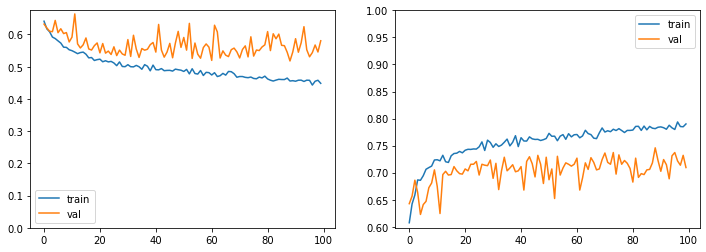

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 15s 3ms/step - loss: 0.5768 - accuracy: 0.5612 - precision: 0.9657 - recall: 0.5327 - f1: 0.6693 - specificity: 0.7948 - negative_predictive_value: 0.1771 - matthews_correlation_coefficient: 0.2156 - val_loss: 0.6029 - val_accuracy: 0.4909 - val_precision: 0.9451 - val_recall: 0.4286 - val_f1: 0.5851 - val_specificity: 0.8680 - val_negative_predictive_value: 0.1584 - val_matthews_correlation_coefficient: 0.2026

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20262, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_21-02_41_17.h5
Epoch 2/100
4610/4610 [==============================] - 20s 4ms/step - loss: 0.5570 - accuracy: 0.5215 - precision: 0.9702 - recall: 0.4721 - f1: 0.6293 - specificity: 0.8848 - negative_predictive_value: 0.1727 - matthews_correlation_coefficient: 0.2223 - val_loss: 0.6194 - val_accuracy: 0.5048 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.30571
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4826 - accuracy: 0.6855 - precision: 0.9717 - recall: 0.6682 - f1: 0.7799 - specificity: 0.8147 - negative_predictive_value: 0.2669 - matthews_correlation_coefficient: 0.3292 - val_loss: 0.5322 - val_accuracy: 0.6288 - val_precision: 0.9524 - val_recall: 0.5803 - val_f1: 0.7189 - val_specificity: 0.8642 - val_negative_predictive_value: 0.2043 - val_matthews_correlation_coefficient: 0.2889

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.30571
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4715 - accuracy: 0.6822 - precision: 0.9764 - recall: 0.6626 - f1: 0.7791 - specificity: 0.8346 - negative_predictive_value: 0.2580 - matthews_correlation_coefficient: 0.3349 - val_loss: 0.5110 - val_accuracy: 0.6522 - val_precision: 0.9589 - val_recall: 0.6016 - val_f1: 0.7368 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4032 - accuracy: 0.7590 - precision: 0.9775 - recall: 0.7472 - f1: 0.8424 - specificity: 0.8456 - negative_predictive_value: 0.3089 - matthews_correlation_coefficient: 0.4033 - val_loss: 0.5855 - val_accuracy: 0.6470 - val_precision: 0.9715 - val_recall: 0.5869 - val_f1: 0.7293 - val_specificity: 0.9676 - val_negative_predictive_value: 0.2484 - val_matthews_correlation_coefficient: 0.3436

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.44796
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4156 - accuracy: 0.7466 - precision: 0.9798 - recall: 0.7334 - f1: 0.8309 - specificity: 0.8353 - negative_predictive_value: 0.3043 - matthews_correlation_coefficient: 0.3954 - val_loss: 0.4692 - val_accuracy: 0.7225 - val_precision: 0.9662 - val_recall: 0.6747 - val_f1: 0.7920 - val_specificity: 0.9155 - val_negative_predictive_value: 0.2659 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3662 - accuracy: 0.7907 - precision: 0.9833 - recall: 0.7809 - f1: 0.8652 - specificity: 0.8328 - negative_predictive_value: 0.3538 - matthews_correlation_coefficient: 0.4479 - val_loss: 0.5425 - val_accuracy: 0.7051 - val_precision: 0.9583 - val_recall: 0.6607 - val_f1: 0.7792 - val_specificity: 0.8826 - val_negative_predictive_value: 0.2459 - val_matthews_correlation_coefficient: 0.3573

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44796
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3732 - accuracy: 0.7725 - precision: 0.9794 - recall: 0.7604 - f1: 0.8502 - specificity: 0.8346 - negative_predictive_value: 0.3283 - matthews_correlation_coefficient: 0.4230 - val_loss: 0.5269 - val_accuracy: 0.6938 - val_precision: 0.9662 - val_recall: 0.6426 - val_f1: 0.7694 - val_specificity: 0.9140 - val_negative_predictive_value: 0.2430 - val_matthews_correlation_coefficie

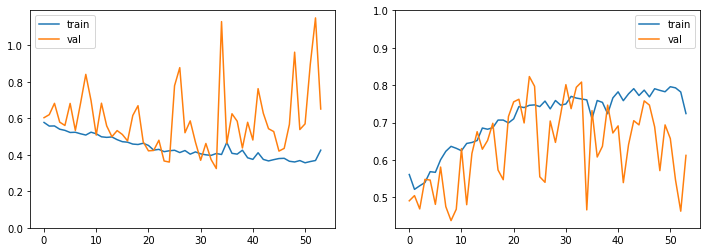

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5909 - accuracy: 0.6570 - precision: 0.9108 - recall: 0.6398 - f1: 0.7421 - specificity: 0.7354 - negative_predictive_value: 0.3415 - matthews_correlation_coefficient: 0.3054 - val_loss: 0.5925 - val_accuracy: 0.6964 - val_precision: 0.8655 - val_recall: 0.6898 - val_f1: 0.7650 - val_specificity: 0.6233 - val_negative_predictive_value: 0.3391 - val_matthews_correlation_coefficient: 0.2793

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27925, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_21-02_55_04.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5712 - accuracy: 0.7041 - precision: 0.9062 - recall: 0.7069 - f1: 0.7897 - specificity: 0.6953 - negative_predictive_value: 0.3700 - matthews_correlation_coefficient: 0.3306 - val_loss: 0.6008 - val_accuracy: 0.6878 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5314 - accuracy: 0.7043 - precision: 0.9238 - recall: 0.6898 - f1: 0.7829 - specificity: 0.7634 - negative_predictive_value: 0.3795 - matthews_correlation_coefficient: 0.3680 - val_loss: 0.5630 - val_accuracy: 0.6782 - val_precision: 0.8885 - val_recall: 0.6454 - val_f1: 0.7448 - val_specificity: 0.7068 - val_negative_predictive_value: 0.3364 - val_matthews_correlation_coefficient: 0.3072

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32975
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5257 - accuracy: 0.7163 - precision: 0.9218 - recall: 0.7091 - f1: 0.7960 - specificity: 0.7495 - negative_predictive_value: 0.3905 - matthews_correlation_coefficient: 0.3762 - val_loss: 0.6257 - val_accuracy: 0.6930 - val_precision: 0.8781 - val_recall: 0.6761 - val_f1: 0.7604 - val_specificity: 0.6540 - val_negative_predictive_value: 0.3421 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40083
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5004 - accuracy: 0.7369 - precision: 0.9262 - recall: 0.7315 - f1: 0.8123 - specificity: 0.7585 - negative_predictive_value: 0.4152 - matthews_correlation_coefficient: 0.4063 - val_loss: 0.5983 - val_accuracy: 0.6678 - val_precision: 0.9033 - val_recall: 0.6175 - val_f1: 0.7302 - val_specificity: 0.7724 - val_negative_predictive_value: 0.3389 - val_matthews_correlation_coefficient: 0.3328

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.40083
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4982 - accuracy: 0.7284 - precision: 0.9240 - recall: 0.7223 - f1: 0.8050 - specificity: 0.7659 - negative_predictive_value: 0.4069 - matthews_correlation_coefficient: 0.3998 - val_loss: 0.6096 - val_accuracy: 0.6791 - val_precision: 0.8922 - val_recall: 0.6431 - val_f1: 0.7449 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.40083 to 0.41972, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_21-02_55_04.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4769 - accuracy: 0.7590 - precision: 0.9332 - recall: 0.7598 - f1: 0.8327 - specificity: 0.7724 - negative_predictive_value: 0.4535 - matthews_correlation_coefficient: 0.4493 - val_loss: 0.6595 - val_accuracy: 0.6340 - val_precision: 0.9177 - val_recall: 0.5639 - val_f1: 0.6941 - val_specificity: 0.8311 - val_negative_predictive_value: 0.3218 - val_matthews_correlation_coefficient: 0.3327

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.41972
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7525 - precision: 0.9208 - recall: 0.7465 - f1: 0.8189 - specificity: 0.7571 - negative_predictive_value: 0.4454 - matthews_correlation_coefficient: 0.4255 - val_


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.41972
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4818 - accuracy: 0.7560 - precision: 0.9291 - recall: 0.7547 - f1: 0.8253 - specificity: 0.7623 - negative_predictive_value: 0.4470 - matthews_correlation_coefficient: 0.4371 - val_loss: 0.6980 - val_accuracy: 0.6470 - val_precision: 0.9180 - val_recall: 0.5790 - val_f1: 0.7054 - val_specificity: 0.8262 - val_negative_predictive_value: 0.3320 - val_matthews_correlation_coefficient: 0.3431

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.41972
Epoch 61/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4659 - accuracy: 0.7614 - precision: 0.9352 - recall: 0.7559 - f1: 0.8309 - specificity: 0.7676 - negative_predictive_value: 0.4487 - matthews_correlation_coefficient: 0.4471 - val_loss: 0.5160 - val_accuracy: 0.7329 - val_precision: 0.9065 - val_recall: 0.6993 - val_f1: 0.7869 - val_sp

Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.41972
Epoch 00074: early stopping

   Final Accuracy:  78.14%
  Final Precision:  91.59%
     Final Recall:  80.11%
  Final F-measure:  85.47%
Final Specificity:  70.18%
        Final NPV:  46.51%
        Final MCC:  43.77%
[[160  68]
 [184 741]]
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       228
           1       0.92      0.80      0.85       925

    accuracy                           0.78      1153
   macro avg       0.69      0.75      0.71      1153
weighted avg       0.83      0.78      0.80      1153



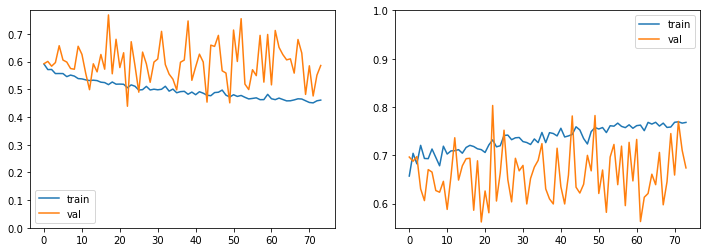

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6641 - accuracy: 0.7243 - precision: 0.9975 - recall: 0.7272 - f1: 0.8151 - specificity: 0.0552 - negative_predictive_value: 0.0035 - matthews_correlation_coefficient: 0.0074 - val_loss: 0.0538 - val_accuracy: 0.9957 - val_precision: 0.9958 - val_recall: 1.0000 - val_f1: 0.9979 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_21-03_06_10.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.7356 - accuracy: 0.6195 - precision: 0.9978 - recall: 0.6229 - f1: 0.7239 - specificity: 0.0621 - negative_predictive_value: 0.0071 - matthews_correlation_coefficient: 0.0122 - val_loss: 0.3128 - val_accuracy: 0.8725

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4800 - accuracy: 0.7050 - precision: 0.9992 - recall: 0.7034 - f1: 0.8195 - specificity: 0.0931 - negative_predictive_value: 0.0155 - matthews_correlation_coefficient: 0.0305 - val_loss: 0.5944 - val_accuracy: 0.6722 - val_precision: 0.9986 - val_recall: 0.6802 - val_f1: 0.8060 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0103 - val_matthews_correlation_coefficient: 0.0238

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.04879
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4270 - accuracy: 0.7876 - precision: 0.9989 - recall: 0.7858 - f1: 0.8775 - specificity: 0.0966 - negative_predictive_value: 0.0140 - matthews_correlation_coefficient: 0.0300 - val_loss: 0.7303 - val_accuracy: 0.6028 - val_precision: 1.0000 - val_recall: 0.6114 - val_f1: 0.7535 - val_specificity: 0.1351 - val_negative_predictive_value: 0.0099 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3455 - accuracy: 0.8113 - precision: 0.9995 - recall: 0.8091 - f1: 0.8916 - specificity: 0.1034 - negative_predictive_value: 0.0206 - matthews_correlation_coefficient: 0.0411 - val_loss: 0.2294 - val_accuracy: 0.9167 - val_precision: 0.9991 - val_recall: 0.9195 - val_f1: 0.9571 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0369 - val_matthews_correlation_coefficient: 0.0590017 - precision: 0.9994 - recall: 0.8019 - f1: 0.8880 - specificity: 0.0862 - negative_predictive_value: 0.017

Epoch 00030: val_matthews_correlation_coefficient improved from 0.04879 to 0.05901, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_21-03_06_10.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3684 - accuracy: 0.8249 - precision: 0.9993 - recall: 0.8261 - f1: 0.9023 - specificity: 0.1000 - negative_predictive_value: 0.0228 - matthews_correlation_coefficient: 0.0393

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2721 - accuracy: 0.8581 - precision: 0.9995 - recall: 0.8588 - f1: 0.9197 - specificity: 0.1034 - negative_predictive_value: 0.0296 - matthews_correlation_coefficient: 0.0462 - val_loss: 0.0930 - val_accuracy: 0.9809 - val_precision: 0.9992 - val_recall: 0.9822 - val_f1: 0.9905 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0541 - val_matthews_correlation_coefficient: 0.0752

Epoch 00044: val_matthews_correlation_coefficient improved from 0.06397 to 0.07520, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_21-03_06_10.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3416 - accuracy: 0.8748 - precision: 0.9995 - recall: 0.8724 - f1: 0.9284 - specificity: 0.1103 - negative_predictive_value: 0.0360 - matthews_correlation_coefficient: 0.0566 - val_loss: 0.4541 - val_accuracy: 0.7832 - val_precision: 0.9989 - val_recall: 0.7887 - val_f1: 0.8795 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3719 - accuracy: 0.8839 - precision: 0.9993 - recall: 0.8850 - f1: 0.9363 - specificity: 0.1034 - negative_predictive_value: 0.0395 - matthews_correlation_coefficient: 0.0587 - val_loss: 0.4599 - val_accuracy: 0.7988 - val_precision: 0.9989 - val_recall: 0.8041 - val_f1: 0.8897 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0159 - val_matthews_correlation_coefficient: 0.0346

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.09165
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4285 - accuracy: 0.7985 - precision: 0.9990 - recall: 0.8000 - f1: 0.8785 - specificity: 0.0966 - negative_predictive_value: 0.0295 - matthews_correlation_coefficient: 0.0439 - val_loss: 0.2361 - val_accuracy: 0.9280 - val_precision: 0.9991 - val_recall: 0.9304 - val_f1: 0.9632 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0324 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2542 - accuracy: 0.9108 - precision: 0.9993 - recall: 0.9117 - f1: 0.9512 - specificity: 0.0966 - negative_predictive_value: 0.0401 - matthews_correlation_coefficient: 0.0547 - val_loss: 0.3554 - val_accuracy: 0.8820 - val_precision: 0.9990 - val_recall: 0.8854 - val_f1: 0.9380 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0189 - val_matthews_correlation_coefficient: 0.0398

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.09165
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2520 - accuracy: 0.8993 - precision: 0.9993 - recall: 0.9002 - f1: 0.9448 - specificity: 0.1000 - negative_predictive_value: 0.0308 - matthews_correlation_coefficient: 0.0498 - val_loss: 0.2427 - val_accuracy: 0.9037 - val_precision: 0.9991 - val_recall: 0.9067 - val_f1: 0.9499 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0360 - val_matthews_correlation_coefficie

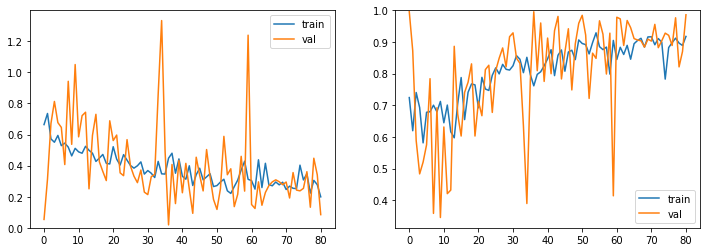

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6002 - accuracy: 0.6213 - precision: 0.8790 - recall: 0.5510 - f1: 0.6582 - specificity: 0.7727 - negative_predictive_value: 0.4031 - matthews_correlation_coefficient: 0.3017 - val_loss: 0.6045 - val_accuracy: 0.6028 - val_precision: 0.8909 - val_recall: 0.4795 - val_f1: 0.6198 - val_specificity: 0.8578 - val_negative_predictive_value: 0.3943 - val_matthews_correlation_coefficient: 0.3358

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33578, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_21-03_18_16.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5931 - accuracy: 0.6102 - precision: 0.8977 - recall: 0.5273 - f1: 0.6533 - specificity: 0.8177 - negative_predictive_value: 0.4031 - matthews_correlation_coefficient: 0.3224 - val_loss: 0.5720 - val_accuracy: 0.6644 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5558 - accuracy: 0.6718 - precision: 0.9079 - recall: 0.6078 - f1: 0.7199 - specificity: 0.8326 - negative_predictive_value: 0.4546 - matthews_correlation_coefficient: 0.3985 - val_loss: 0.5128 - val_accuracy: 0.7121 - val_precision: 0.8578 - val_recall: 0.6737 - val_f1: 0.7508 - val_specificity: 0.7375 - val_negative_predictive_value: 0.4788 - val_matthews_correlation_coefficient: 0.3981

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.41422
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5476 - accuracy: 0.6768 - precision: 0.9158 - recall: 0.6140 - f1: 0.7265 - specificity: 0.8504 - negative_predictive_value: 0.4634 - matthews_correlation_coefficient: 0.4194 - val_loss: 0.5946 - val_accuracy: 0.6487 - val_precision: 0.9214 - val_recall: 0.5284 - val_f1: 0.6675 - val_specificity: 0.8952 - val_negative_predictive_value: 0.4292 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5232 - accuracy: 0.6996 - precision: 0.9110 - recall: 0.6369 - f1: 0.7421 - specificity: 0.8432 - negative_predictive_value: 0.4825 - matthews_correlation_coefficient: 0.4329 - val_loss: 0.6494 - val_accuracy: 0.6149 - val_precision: 0.9260 - val_recall: 0.4785 - val_f1: 0.6259 - val_specificity: 0.9069 - val_negative_predictive_value: 0.4081 - val_matthews_correlation_coefficient: 0.3841

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43172
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5257 - accuracy: 0.6948 - precision: 0.9262 - recall: 0.6270 - f1: 0.7395 - specificity: 0.8590 - negative_predictive_value: 0.4775 - matthews_correlation_coefficient: 0.4422 - val_loss: 0.5585 - val_accuracy: 0.6730 - val_precision: 0.9124 - val_recall: 0.5690 - val_f1: 0.6965 - val_specificity: 0.8783 - val_negative_predictive_value: 0.4496 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5009 - accuracy: 0.7152 - precision: 0.9278 - recall: 0.6589 - f1: 0.7639 - specificity: 0.8575 - negative_predictive_value: 0.4976 - matthews_correlation_coefficient: 0.4687 - val_loss: 0.4926 - val_accuracy: 0.7138 - val_precision: 0.8603 - val_recall: 0.6741 - val_f1: 0.7519 - val_specificity: 0.7504 - val_negative_predictive_value: 0.4867 - val_matthews_correlation_coefficient: 0.4099

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43942
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4976 - accuracy: 0.7197 - precision: 0.9227 - recall: 0.6704 - f1: 0.7706 - specificity: 0.8555 - negative_predictive_value: 0.5079 - matthews_correlation_coefficient: 0.4740 - val_loss: 0.5823 - val_accuracy: 0.6696 - val_precision: 0.9118 - val_recall: 0.5646 - val_f1: 0.6937 - val_specificity: 0.8716 - val_negative_predictive_value: 0.4432 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.44931
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4978 - accuracy: 0.7228 - precision: 0.9243 - recall: 0.6736 - f1: 0.7726 - specificity: 0.8563 - negative_predictive_value: 0.5153 - matthews_correlation_coefficient: 0.4810 - val_loss: 0.6305 - val_accuracy: 0.6687 - val_precision: 0.9232 - val_recall: 0.5571 - val_f1: 0.6899 - val_specificity: 0.8924 - val_negative_predictive_value: 0.4456 - val_matthews_correlation_coefficient: 0.4326

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.44931
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4882 - accuracy: 0.7297 - precision: 0.9290 - recall: 0.6755 - f1: 0.7756 - specificity: 0.8645 - negative_predictive_value: 0.5126 - matthews_correlation_coefficient: 0.4879 - val_loss: 0.5051 - val_accuracy: 0.7173 - val_precision: 0.8899 - val_recall: 0.6510 - val_f1: 0.7471 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.45063
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4802 - accuracy: 0.7312 - precision: 0.9197 - recall: 0.6799 - f1: 0.7758 - specificity: 0.8552 - negative_predictive_value: 0.5182 - matthews_correlation_coefficient: 0.4824 - val_loss: 0.5987 - val_accuracy: 0.6592 - val_precision: 0.9207 - val_recall: 0.5432 - val_f1: 0.6782 - val_specificity: 0.8933 - val_negative_predictive_value: 0.4399 - val_matthews_correlation_coefficient: 0.4222

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.45063
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4853 - accuracy: 0.7304 - precision: 0.9216 - recall: 0.6765 - f1: 0.7746 - specificity: 0.8691 - negative_predictive_value: 0.5190 - matthews_correlation_coefficient: 0.4904 - val_loss: 0.5272 - val_accuracy: 0.6956 - val_precision: 0.8894 - val_recall: 0.6194 - val_f1: 0.7255 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.45905
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4795 - accuracy: 0.7310 - precision: 0.9219 - recall: 0.6760 - f1: 0.7746 - specificity: 0.8632 - negative_predictive_value: 0.5158 - matthews_correlation_coefficient: 0.4911 - val_loss: 0.5865 - val_accuracy: 0.6704 - val_precision: 0.9227 - val_recall: 0.5598 - val_f1: 0.6915 - val_specificity: 0.8906 - val_negative_predictive_value: 0.4480 - val_matthews_correlation_coefficient: 0.4341

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.45905
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4718 - accuracy: 0.7460 - precision: 0.9266 - recall: 0.7047 - f1: 0.7958 - specificity: 0.8529 - negative_predictive_value: 0.5299 - matthews_correlation_coefficient: 0.5030 - val_loss: 0.5868 - val_accuracy: 0.6782 - val_precision: 0.9124 - val_recall: 0.5770 - val_f1: 0.7014 - val_spe

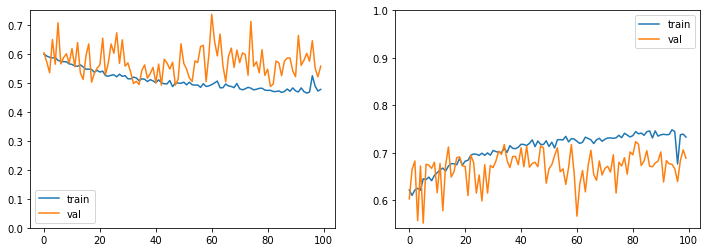

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6035 - accuracy: 0.6106 - precision: 0.9149 - recall: 0.5962 - f1: 0.7079 - specificity: 0.7172 - negative_predictive_value: 0.2406 - matthews_correlation_coefficient: 0.2238 - val_loss: 0.6024 - val_accuracy: 0.5672 - val_precision: 0.9493 - val_recall: 0.5370 - val_f1: 0.6764 - val_specificity: 0.8351 - val_negative_predictive_value: 0.2234 - val_matthews_correlation_coefficient: 0.2474

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24736, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_21-03_33_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5718 - accuracy: 0.6093 - precision: 0.9355 - recall: 0.5867 - f1: 0.7057 - specificity: 0.7619 - negative_predictive_value: 0.2490 - matthews_correlation_coefficient: 0.2501 - val_loss: 0.5850 - val_accuracy: 0.6539 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38168
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5011 - accuracy: 0.7148 - precision: 0.9522 - recall: 0.7035 - f1: 0.8029 - specificity: 0.7755 - negative_predictive_value: 0.3186 - matthews_correlation_coefficient: 0.3566 - val_loss: 0.4562 - val_accuracy: 0.7797 - val_precision: 0.9322 - val_recall: 0.8073 - val_f1: 0.8627 - val_specificity: 0.6587 - val_negative_predictive_value: 0.3552 - val_matthews_correlation_coefficient: 0.3584

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.38168
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4981 - accuracy: 0.7262 - precision: 0.9494 - recall: 0.7181 - f1: 0.8120 - specificity: 0.7636 - negative_predictive_value: 0.3248 - matthews_correlation_coefficient: 0.3592 - val_loss: 0.5190 - val_accuracy: 0.7008 - val_precision: 0.9657 - val_recall: 0.6837 - val_f1: 0.7950 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4706 - accuracy: 0.7399 - precision: 0.9484 - recall: 0.7269 - f1: 0.8184 - specificity: 0.7841 - negative_predictive_value: 0.3375 - matthews_correlation_coefficient: 0.3829 - val_loss: 0.6179 - val_accuracy: 0.6262 - val_precision: 0.9822 - val_recall: 0.5869 - val_f1: 0.7264 - val_specificity: 0.9000 - val_negative_predictive_value: 0.2686 - val_matthews_correlation_coefficient: 0.3447

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43712
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5280 - accuracy: 0.7033 - precision: 0.9418 - recall: 0.6968 - f1: 0.7812 - specificity: 0.7627 - negative_predictive_value: 0.3409 - matthews_correlation_coefficient: 0.3538 - val_loss: 0.4348 - val_accuracy: 0.7866 - val_precision: 0.9531 - val_recall: 0.7964 - val_f1: 0.8649 - val_specificity: 0.7658 - val_negative_predictive_value: 0.3860 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.44247
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4392 - accuracy: 0.7603 - precision: 0.9611 - recall: 0.7547 - f1: 0.8407 - specificity: 0.7967 - negative_predictive_value: 0.3597 - matthews_correlation_coefficient: 0.4152 - val_loss: 0.3641 - val_accuracy: 0.8291 - val_precision: 0.9311 - val_recall: 0.8704 - val_f1: 0.8978 - val_specificity: 0.6299 - val_negative_predictive_value: 0.4507 - val_matthews_correlation_coefficient: 0.4252

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44247
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4388 - accuracy: 0.7685 - precision: 0.9599 - recall: 0.7628 - f1: 0.8452 - specificity: 0.7947 - negative_predictive_value: 0.3688 - matthews_correlation_coefficient: 0.4205 - val_loss: 0.3551 - val_accuracy: 0.8335 - val_precision: 0.9311 - val_recall: 0.8746 - val_f1: 0.9004 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.44247
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4159 - accuracy: 0.7816 - precision: 0.9623 - recall: 0.7767 - f1: 0.8554 - specificity: 0.8031 - negative_predictive_value: 0.3854 - matthews_correlation_coefficient: 0.4407 - val_loss: 0.4004 - val_accuracy: 0.7918 - val_precision: 0.9656 - val_recall: 0.7917 - val_f1: 0.8674 - val_specificity: 0.8039 - val_negative_predictive_value: 0.3847 - val_matthews_correlation_coefficient: 0.4496

Epoch 00059: val_matthews_correlation_coefficient improved from 0.44247 to 0.44961, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_21-03_33_28.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4111 - accuracy: 0.7859 - precision: 0.9648 - recall: 0.7812 - f1: 0.8589 - specificity: 0.8198 - negative_predictive_value: 0.3980 - matthews_correlation_coefficient: 0.4591 - val_loss: 0.3482 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4246 - accuracy: 0.7829 - precision: 0.9624 - recall: 0.7793 - f1: 0.8564 - specificity: 0.8065 - negative_predictive_value: 0.3898 - matthews_correlation_coefficient: 0.4459 - val_loss: 0.4305 - val_accuracy: 0.7849 - val_precision: 0.9516 - val_recall: 0.7960 - val_f1: 0.8646 - val_specificity: 0.7411 - val_negative_predictive_value: 0.3705 - val_matthews_correlation_coefficient: 0.4079

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.45905
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3940 - accuracy: 0.7980 - precision: 0.9639 - recall: 0.7932 - f1: 0.8659 - specificity: 0.8362 - negative_predictive_value: 0.4138 - matthews_correlation_coefficient: 0.4799 - val_loss: 0.3424 - val_accuracy: 0.8387 - val_precision: 0.9279 - val_recall: 0.8845 - val_f1: 0.9040 - val_specificity: 0.5927 - val_negative_predictive_value: 0.4750 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.47852
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3831 - accuracy: 0.7959 - precision: 0.9601 - recall: 0.7842 - f1: 0.8592 - specificity: 0.8267 - negative_predictive_value: 0.4045 - matthews_correlation_coefficient: 0.4654 - val_loss: 0.3860 - val_accuracy: 0.8144 - val_precision: 0.9515 - val_recall: 0.8324 - val_f1: 0.8860 - val_specificity: 0.7284 - val_negative_predictive_value: 0.4108 - val_matthews_correlation_coefficient: 0.4423

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.47852
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4400 - accuracy: 0.7662 - precision: 0.9641 - recall: 0.7577 - f1: 0.8381 - specificity: 0.8224 - negative_predictive_value: 0.3940 - matthews_correlation_coefficient: 0.4478 - val_loss: 0.3095 - val_accuracy: 0.8647 - val_precision: 0.9300 - val_recall: 0.9157 - val_f1: 0.9215 - val_spe

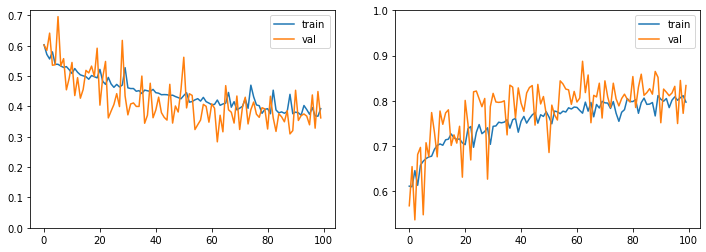

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4178 - accuracy: 0.7698 - precision: 0.9915 - recall: 0.7603 - f1: 0.8525 - specificity: 0.7891 - negative_predictive_value: 0.2231 - matthews_correlation_coefficient: 0.3430 - val_loss: 0.3861 - val_accuracy: 0.8291 - val_precision: 0.9636 - val_recall: 0.8037 - val_f1: 0.8752 - val_specificity: 0.7973 - val_negative_predictive_value: 0.2465 - val_matthews_correlation_coefficient: 0.3767

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37672, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_21-03_48_24.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3272 - accuracy: 0.8727 - precision: 0.9916 - recall: 0.8701 - f1: 0.9250 - specificity: 0.7173 - negative_predictive_value: 0.3146 - matthews_correlation_coefficient: 0.4189 - val_loss: 0.3647 - val_accuracy: 0.8621 - val_precis

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2592 - accuracy: 0.9061 - precision: 0.9930 - recall: 0.9072 - f1: 0.9472 - specificity: 0.7922 - negative_predictive_value: 0.3873 - matthews_correlation_coefficient: 0.5047 - val_loss: 0.2518 - val_accuracy: 0.9141 - val_precision: 0.9641 - val_recall: 0.8930 - val_f1: 0.9266 - val_specificity: 0.7838 - val_negative_predictive_value: 0.4028 - val_matthews_correlation_coefficient: 0.5167

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.53259
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2592 - accuracy: 0.9087 - precision: 0.9926 - recall: 0.9107 - f1: 0.9488 - specificity: 0.7890 - negative_predictive_value: 0.4202 - matthews_correlation_coefficient: 0.5267 - val_loss: 0.2078 - val_accuracy: 0.9315 - val_precision: 0.9643 - val_recall: 0.9107 - val_f1: 0.9364 - val_specificity: 0.7838 - val_negative_predictive_value: 0.4544 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2291 - accuracy: 0.9167 - precision: 0.9930 - recall: 0.9155 - f1: 0.9512 - specificity: 0.7353 - negative_predictive_value: 0.4297 - matthews_correlation_coefficient: 0.5210 - val_loss: 0.2526 - val_accuracy: 0.9098 - val_precision: 0.9661 - val_recall: 0.8862 - val_f1: 0.9239 - val_specificity: 0.8041 - val_negative_predictive_value: 0.3766 - val_matthews_correlation_coefficient: 0.5069

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.58055
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2206 - accuracy: 0.9258 - precision: 0.9901 - recall: 0.9281 - f1: 0.9562 - specificity: 0.7715 - negative_predictive_value: 0.4726 - matthews_correlation_coefficient: 0.5611 - val_loss: 0.3473 - val_accuracy: 0.8829 - val_precision: 0.9658 - val_recall: 0.8582 - val_f1: 0.9081 - val_specificity: 0.8041 - val_negative_predictive_value: 0.3184 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.61284
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1873 - accuracy: 0.9382 - precision: 0.9936 - recall: 0.9380 - f1: 0.9637 - specificity: 0.7568 - negative_predictive_value: 0.5039 - matthews_correlation_coefficient: 0.5787 - val_loss: 0.2730 - val_accuracy: 0.9107 - val_precision: 0.9640 - val_recall: 0.8889 - val_f1: 0.9244 - val_specificity: 0.7838 - val_negative_predictive_value: 0.3807 - val_matthews_correlation_coefficient: 0.5021

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.61284
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1978 - accuracy: 0.9354 - precision: 0.9943 - recall: 0.9370 - f1: 0.9640 - specificity: 0.8146 - negative_predictive_value: 0.4889 - matthews_correlation_coefficient: 0.5898 - val_loss: 0.1544 - val_accuracy: 0.9445 - val_precision: 0.9644 - val_recall: 0.9244 - val_f1: 0.9436 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1820 - accuracy: 0.9427 - precision: 0.9943 - recall: 0.9447 - f1: 0.9681 - specificity: 0.7746 - negative_predictive_value: 0.5232 - matthews_correlation_coefficient: 0.6003 - val_loss: 0.2150 - val_accuracy: 0.9237 - val_precision: 0.9660 - val_recall: 0.9006 - val_f1: 0.9319 - val_specificity: 0.8018 - val_negative_predictive_value: 0.4089 - val_matthews_correlation_coefficient: 0.5338

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.62017
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1872 - accuracy: 0.9395 - precision: 0.9948 - recall: 0.9406 - f1: 0.9655 - specificity: 0.8500 - negative_predictive_value: 0.5662 - matthews_correlation_coefficient: 0.6527 - val_loss: 0.2665 - val_accuracy: 0.9072 - val_precision: 0.9659 - val_recall: 0.8836 - val_f1: 0.9224 - val_specificity: 0.8018 - val_negative_predictive_value: 0.3709 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.69434
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1448 - accuracy: 0.9471 - precision: 0.9952 - recall: 0.9484 - f1: 0.9704 - specificity: 0.8250 - negative_predictive_value: 0.5635 - matthews_correlation_coefficient: 0.6475 - val_loss: 0.2390 - val_accuracy: 0.9133 - val_precision: 0.9659 - val_recall: 0.8898 - val_f1: 0.9260 - val_specificity: 0.8018 - val_negative_predictive_value: 0.3779 - val_matthews_correlation_coefficient: 0.5090

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.69434
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1371 - accuracy: 0.9531 - precision: 0.9961 - recall: 0.9541 - f1: 0.9741 - specificity: 0.8392 - negative_predictive_value: 0.5690 - matthews_correlation_coefficient: 0.6586 - val_loss: 0.2020 - val_accuracy: 0.9271 - val_precision: 0.9660 - val_recall: 0.9045 - val_f1: 0.9338 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.69434
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4137 - accuracy: 0.8616 - precision: 0.9920 - recall: 0.8582 - f1: 0.9098 - specificity: 0.7799 - negative_predictive_value: 0.3657 - matthews_correlation_coefficient: 0.4714 - val_loss: 0.1820 - val_accuracy: 0.9384 - val_precision: 0.9914 - val_recall: 0.9444 - val_f1: 0.9670 - val_specificity: 0.7838 - val_negative_predictive_value: 0.4695 - val_matthews_correlation_coefficient: 0.5700

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.69434
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2145 - accuracy: 0.9256 - precision: 0.9945 - recall: 0.9270 - f1: 0.9584 - specificity: 0.7898 - negative_predictive_value: 0.4778 - matthews_correlation_coefficient: 0.5708 - val_loss: 0.2385 - val_accuracy: 0.9176 - val_precision: 0.9641 - val_recall: 0.8962 - val_f1: 0.9284 - val_spe

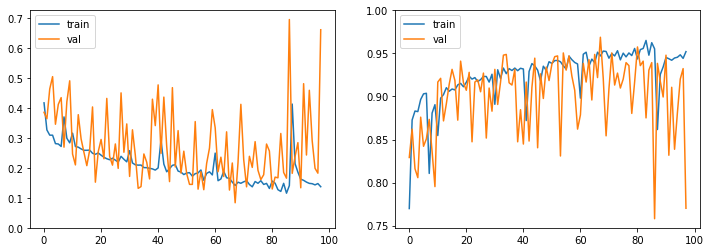

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6085 - accuracy: 0.6254 - precision: 0.8826 - recall: 0.5755 - f1: 0.6881 - specificity: 0.7801 - negative_predictive_value: 0.3829 - matthews_correlation_coefficient: 0.3082 - val_loss: 0.6302 - val_accuracy: 0.6167 - val_precision: 0.8701 - val_recall: 0.5352 - val_f1: 0.6587 - val_specificity: 0.8164 - val_negative_predictive_value: 0.3906 - val_matthews_correlation_coefficient: 0.3010

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30096, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_21-04_03_03.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5836 - accuracy: 0.6685 - precision: 0.8943 - recall: 0.6363 - f1: 0.7376 - specificity: 0.7663 - negative_predictive_value: 0.4089 - matthews_correlation_coefficient: 0.3486 - val_loss: 0.6275 - val_accuracy: 0.6548 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38734
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5429 - accuracy: 0.6998 - precision: 0.9069 - recall: 0.6712 - f1: 0.7660 - specificity: 0.7856 - negative_predictive_value: 0.4447 - matthews_correlation_coefficient: 0.4002 - val_loss: 0.6312 - val_accuracy: 0.6392 - val_precision: 0.8900 - val_recall: 0.5527 - val_f1: 0.6767 - val_specificity: 0.8447 - val_negative_predictive_value: 0.4112 - val_matthews_correlation_coefficient: 0.3437

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.38734
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5450 - accuracy: 0.6961 - precision: 0.9047 - recall: 0.6586 - f1: 0.7565 - specificity: 0.8003 - negative_predictive_value: 0.4408 - matthews_correlation_coefficient: 0.4029 - val_loss: 0.5551 - val_accuracy: 0.6895 - val_precision: 0.8862 - val_recall: 0.6287 - val_f1: 0.7323 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5299 - accuracy: 0.7141 - precision: 0.9121 - recall: 0.6913 - f1: 0.7818 - specificity: 0.7915 - negative_predictive_value: 0.4563 - matthews_correlation_coefficient: 0.4193 - val_loss: 0.4887 - val_accuracy: 0.7441 - val_precision: 0.8648 - val_recall: 0.7316 - val_f1: 0.7900 - val_specificity: 0.7081 - val_negative_predictive_value: 0.5008 - val_matthews_correlation_coefficient: 0.3993

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41092
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5257 - accuracy: 0.7206 - precision: 0.9046 - recall: 0.6930 - f1: 0.7803 - specificity: 0.7784 - negative_predictive_value: 0.4591 - matthews_correlation_coefficient: 0.4194 - val_loss: 0.5695 - val_accuracy: 0.6869 - val_precision: 0.8927 - val_recall: 0.6179 - val_f1: 0.7270 - val_specificity: 0.8388 - val_negative_predictive_value: 0.4488 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43034
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5155 - accuracy: 0.7275 - precision: 0.9134 - recall: 0.7022 - f1: 0.7896 - specificity: 0.7926 - negative_predictive_value: 0.4677 - matthews_correlation_coefficient: 0.4334 - val_loss: 0.4820 - val_accuracy: 0.7502 - val_precision: 0.8795 - val_recall: 0.7239 - val_f1: 0.7908 - val_specificity: 0.7584 - val_negative_predictive_value: 0.5124 - val_matthews_correlation_coefficient: 0.4325

Epoch 00044: val_matthews_correlation_coefficient improved from 0.43034 to 0.43254, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_21-04_03_03.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5131 - accuracy: 0.7230 - precision: 0.9034 - recall: 0.6962 - f1: 0.7823 - specificity: 0.7937 - negative_predictive_value: 0.4670 - matthews_correlation_coefficient: 0.4257 - val_loss: 0.5493 - v


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43254
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5034 - accuracy: 0.7293 - precision: 0.9118 - recall: 0.7074 - f1: 0.7923 - specificity: 0.7861 - negative_predictive_value: 0.4746 - matthews_correlation_coefficient: 0.4366 - val_loss: 0.4783 - val_accuracy: 0.7337 - val_precision: 0.8611 - val_recall: 0.7204 - val_f1: 0.7823 - val_specificity: 0.6942 - val_negative_predictive_value: 0.4821 - val_matthews_correlation_coefficient: 0.3762

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43254
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5014 - accuracy: 0.7302 - precision: 0.9145 - recall: 0.7051 - f1: 0.7921 - specificity: 0.7960 - negative_predictive_value: 0.4738 - matthews_correlation_coefficient: 0.4404 - val_loss: 0.5441 - val_accuracy: 0.7008 - val_precision: 0.8922 - val_recall: 0.6389 - val_f1: 0.7411 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.43254
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4925 - accuracy: 0.7332 - precision: 0.9205 - recall: 0.7041 - f1: 0.7931 - specificity: 0.8106 - negative_predictive_value: 0.4804 - matthews_correlation_coefficient: 0.4540 - val_loss: 0.5163 - val_accuracy: 0.7129 - val_precision: 0.8836 - val_recall: 0.6645 - val_f1: 0.7558 - val_specificity: 0.7984 - val_negative_predictive_value: 0.4692 - val_matthews_correlation_coefficient: 0.4021
Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.43254
Epoch 00074: early stopping

   Final Accuracy:  75.02%
  Final Precision:  90.48%
     Final Recall:  74.60%
  Final F-measure:  81.77%
Final Specificity:  76.31%
        Final NPV:  49.89%
        Final MCC:  45.33%
[[219  68]
 [220 646]]
              precision    recall  f1-score   support

           0     

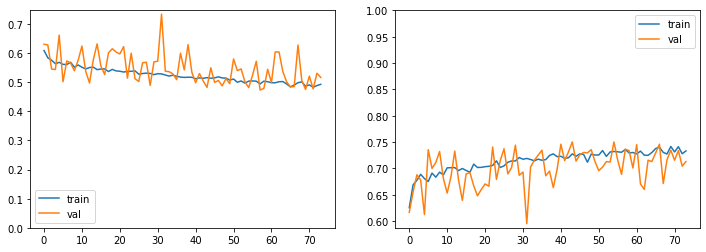

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4567 - accuracy: 0.7696 - precision: 0.9962 - recall: 0.7671 - f1: 0.8583 - specificity: 0.3069 - negative_predictive_value: 0.0513 - matthews_correlation_coefficient: 0.0957 - val_loss: 0.8954 - val_accuracy: 0.5343 - val_precision: 0.9730 - val_recall: 0.5143 - val_f1: 0.6676 - val_specificity: 0.3243 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0687

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06875, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_21-04_14_12.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3614 - accuracy: 0.8117 - precision: 0.9987 - recall: 0.8117 - f1: 0.8921 - specificity: 0.3057 - negative_predictive_value: 0.0729 - matthews_correlation_coefficient: 0.1283 - val_loss: 0.2716 - val_accuracy: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.12981
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3181 - accuracy: 0.8117 - precision: 0.9992 - recall: 0.8111 - f1: 0.8915 - specificity: 0.3218 - negative_predictive_value: 0.0727 - matthews_correlation_coefficient: 0.1314 - val_loss: 0.3800 - val_accuracy: 0.8127 - val_precision: 0.9980 - val_recall: 0.8169 - val_f1: 0.8964 - val_specificity: 0.2838 - val_negative_predictive_value: 0.0596 - val_matthews_correlation_coefficient: 0.1143

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.12981
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3171 - accuracy: 0.8219 - precision: 0.9992 - recall: 0.8183 - f1: 0.8979 - specificity: 0.3483 - negative_predictive_value: 0.0734 - matthews_correlation_coefficient: 0.1423 - val_loss: 0.2960 - val_accuracy: 0.8482 - val_precision: 0.9980 - val_recall: 0.8520 - val_f1: 0.9177 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.13733
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2776 - accuracy: 0.8495 - precision: 0.9990 - recall: 0.8493 - f1: 0.9170 - specificity: 0.3414 - negative_predictive_value: 0.0760 - matthews_correlation_coefficient: 0.1443 - val_loss: 0.3569 - val_accuracy: 0.8352 - val_precision: 1.0000 - val_recall: 0.8374 - val_f1: 0.9100 - val_specificity: 0.3243 - val_negative_predictive_value: 0.0727 - val_matthews_correlation_coefficient: 0.1402

Epoch 00030: val_matthews_correlation_coefficient improved from 0.13733 to 0.14018, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_21-04_14_12.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2833 - accuracy: 0.8369 - precision: 0.9992 - recall: 0.8365 - f1: 0.9093 - specificity: 0.3080 - negative_predictive_value: 0.0751 - matthews_correlation_coefficient: 0.1354 -


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.15563
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2615 - accuracy: 0.8586 - precision: 0.9997 - recall: 0.8578 - f1: 0.9224 - specificity: 0.3517 - negative_predictive_value: 0.0817 - matthews_correlation_coefficient: 0.1538 - val_loss: 0.2263 - val_accuracy: 0.8734 - val_precision: 0.9980 - val_recall: 0.8767 - val_f1: 0.9320 - val_specificity: 0.2838 - val_negative_predictive_value: 0.0820 - val_matthews_correlation_coefficient: 0.1387

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.15563
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2579 - accuracy: 0.8557 - precision: 0.9993 - recall: 0.8556 - f1: 0.9207 - specificity: 0.3690 - negative_predictive_value: 0.0930 - matthews_correlation_coefficient: 0.1676 - val_loss: 0.3321 - val_accuracy: 0.8422 - val_precision: 1.0000 - val_recall: 0.8443 - val_f1: 0.9140 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2569 - accuracy: 0.8499 - precision: 0.9988 - recall: 0.8502 - f1: 0.9171 - specificity: 0.3190 - negative_predictive_value: 0.0829 - matthews_correlation_coefficient: 0.1457 - val_loss: 0.3484 - val_accuracy: 0.8474 - val_precision: 1.0000 - val_recall: 0.8494 - val_f1: 0.9171 - val_specificity: 0.3243 - val_negative_predictive_value: 0.0809 - val_matthews_correlation_coefficient: 0.1483

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.15787
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2585 - accuracy: 0.8382 - precision: 0.9992 - recall: 0.8379 - f1: 0.9091 - specificity: 0.3276 - negative_predictive_value: 0.0860 - matthews_correlation_coefficient: 0.1483 - val_loss: 0.2049 - val_accuracy: 0.8794 - val_precision: 0.9991 - val_recall: 0.8819 - val_f1: 0.9355 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0894 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2396 - accuracy: 0.8599 - precision: 0.9995 - recall: 0.8593 - f1: 0.9225 - specificity: 0.3759 - negative_predictive_value: 0.0915 - matthews_correlation_coefficient: 0.1677 - val_loss: 0.2615 - val_accuracy: 0.8812 - val_precision: 1.0000 - val_recall: 0.8826 - val_f1: 0.9363 - val_specificity: 0.3243 - val_negative_predictive_value: 0.0914 - val_matthews_correlation_coefficient: 0.1599

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.17578
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2325 - accuracy: 0.8642 - precision: 0.9992 - recall: 0.8640 - f1: 0.9254 - specificity: 0.3241 - negative_predictive_value: 0.0861 - matthews_correlation_coefficient: 0.1507 - val_loss: 0.3005 - val_accuracy: 0.8534 - val_precision: 1.0000 - val_recall: 0.8552 - val_f1: 0.9204 - val_specificity: 0.3243 - val_negative_predictive_value: 0.0796 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.17741
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2434 - accuracy: 0.8633 - precision: 0.9992 - recall: 0.8598 - f1: 0.9228 - specificity: 0.3138 - negative_predictive_value: 0.0835 - matthews_correlation_coefficient: 0.1451 - val_loss: 0.3167 - val_accuracy: 0.8439 - val_precision: 1.0000 - val_recall: 0.8458 - val_f1: 0.9148 - val_specificity: 0.3243 - val_negative_predictive_value: 0.0746 - val_matthews_correlation_coefficient: 0.1404

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.17741
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2585 - accuracy: 0.8529 - precision: 0.9995 - recall: 0.8492 - f1: 0.9149 - specificity: 0.3297 - negative_predictive_value: 0.0912 - matthews_correlation_coefficient: 0.1551 - val_loss: 0.4540 - val_accuracy: 0.7693 - val_precision: 1.0000 - val_recall: 0.7724 - val_f1: 0.8689 - val_spe

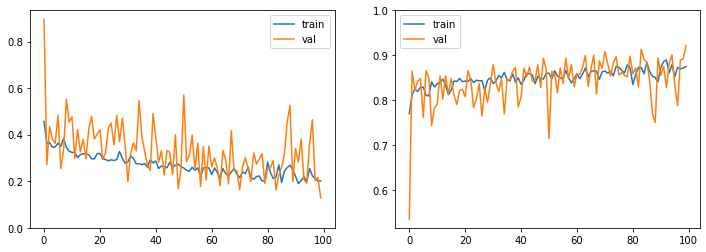

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_20-23_42_08.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_20-23_53_11.h5'
 '../models/autoencoders_requirements/ink_marked_creased_2020_03_21-00_01_48.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_21-00_07_03.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_21-00_14_54.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_21-00_29_50.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_21-00_44_14.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_21-00_52_42.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_21-01_07_26.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_21-01_17_05.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_21-01_31_50.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_21-01_46_35.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_21-01_56_43.h5'
 

In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5')

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

list_files = glob('../data/pybossa/images/*')
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images\FRGC_04239d154.jpg
1 of 1


[array([[0.29053706]], dtype=float32),
 array([[0.71503234]], dtype=float32),
 array([[0.33204198]], dtype=float32),
 array([[0.1848982]], dtype=float32),
 array([[0.9523278]], dtype=float32),
 array([[0.9999286]], dtype=float32),
 array([[0.5714735]], dtype=float32),
 array([[0.997077]], dtype=float32),
 array([[0.86793363]], dtype=float32),
 array([[0.01574569]], dtype=float32),
 array([[0.9621221]], dtype=float32),
 array([[0.10863773]], dtype=float32),
 array([[0.65987074]], dtype=float32),
 array([[0.09829434]], dtype=float32),
 array([[0.20445128]], dtype=float32),
 array([[0.9999001]], dtype=float32),
 array([[0.7171451]], dtype=float32),
 array([[0.9999963]], dtype=float32),
 array([[0.9692727]], dtype=float32),
 array([[0.517223]], dtype=float32),
 array([[0.99998903]], dtype=float32),
 array([[0.6713809]], dtype=float32),
 array([[0.16103208]], dtype=float32)]